In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import matplotlib.image as mpimg

%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure
from scipy.ndimage import gaussian_filter
from statsmodels.formula.api import ols
from scipy.stats import t
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from landlab.utils.flow__distance import calculate_flow__distance
from landlab.utils import watershed
from scipy.odr import *

In [2]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def slopeWindowMperM(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_m_per_m = rise_run
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_m_per_m
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = 2 * ((D*H**2 + E*G**2 - F*G*H) / (G**2 + H**2))
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = -2 * (D*G**2 + E*H**2 + F*G*H) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def differenceFromMeanElevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def ghFilter(gully_heads):
    """Reduce the number of candidate initial gully heads. The window size is custimizable through the 
    'footprint' argument. """
    surrounding_nodes_list = [];
    for i in range(0, num_values):
        if i != central_value:
            surrounding_nodes_list.append(gully_heads[i])
    
    surrounding_nodes_array = np.array(surrounding_nodes_list)
    non_zero_values = surrounding_nodes_array[surrounding_nodes_array > 0]
    if non_zero_values.size == 0:
        new_value = 0  
    else:
        if gully_heads[central_value] > 0 and np.min(non_zero_values) > gully_heads[central_value]:
            new_value = 1
        else:
            new_value = 0

    return new_value
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10
def catchmentDicts(area_grid, gn, gh_nodes):
    """Creates a dictionary of node ID:catcment area values."""
    area_dict = {}
    nodes = gh_nodes
    x_axis_length = gn.shape[1]
    for i in nodes:
        row = int(np.floor(i / x_axis_length))
        col = int(i - (row*x_axis_length))
        area = area_grid[row,col]
        area_dict[i] = area
    return area_dict
def upslopeDivergence(catchment_area_list, change_detection_factor, step_size, comparison_distance):
    
    """"Looks at whether catchment area is increasing at any point upstream of a gully head.
    
    - 'catchment_area_list' is an ordered list of node catchment areas moving upstream.
    
    - 'change_detection_factor' is the percentage increase required for the function to consider the change
    to represent a point of divergent flow.
    
    - 'step_size' is the number of grid cells to be compared in downstream to upstream groups. E.g. step_size == 1 
    will compare node 1 and node 2, but step_size == 2 will compare node 1 and 2 to node 3 and 4.
    
    - 'comparison_distance' is the distance between the downstream nodes being compared to upstream nodes."""
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        required_catchment_area_increase = max(downstream_nodes) + (max(downstream_nodes) * change_detection_factor)
        
        if all(nodes >= required_catchment_area_increase for nodes in upstream_nodes):
            divergence = 1
            break
        else:
            divergence = 0
    return divergence
def findGullyHeadNode(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node, contributing_fraction, required_ca):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if np.amax(grid_cell_receiver_nodes) < contributing_fraction or node_ca < required_ca:
                # Check if this is the last possible grid cell in the subset that could meet the criteria. If so, then there
                # is no suitable grid cell (node).
                if j == distance_from_node - 1:
                    catchment_area_dict[i] = 'No grid cell found'
                else:
                    # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                    # in the next iteration.
                    index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                    next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def findPoint5mDownstream(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if j + 1 < distance_from_node:
                
                # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                # in the next iteration.
                index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                print(j)
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def closest(lst, K): 
     angle_list = lst
     index_pos = (np.abs(angle_list - K)).argmin() 
     return angle_list[index_pos]  
def data_range(data):
    data_min = np.amin(data); data_max = np.amax(data)
    value_range = data_max - data_min
    return value_range
def checkGullyHead(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyHeadElev(dfme_list, elev_list, step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size      
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_upstream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_upstream_nodes]
        
        #min_downstream = np.min(downstream_nodes)
        min_downstream = np.max(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        #std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])
        elevation_difference = np.median(elev_list[start_of_upstream_nodes:end_of_upstream_nodes]) - np.median(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.5 and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def upstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         min_depth, gh_elevation):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    gully_head_elevation_stdev = []
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}

    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
                
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        flattened_elevation = dem_subset.reshape(da.shape)
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.       

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        node_dfme_dict = {}
        node_elevation_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_dfme_dict = {};
            upstream_elevation_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8 for the MFD8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j];
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value);
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da));
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow;
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset));
                        upstream_original_node_id.update({node_id_value:original_node_id});
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme));
                        upstream_dfme_dict.update({node_id_value:node_dfme});
                        node_elevation = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_elevation));
                        upstream_elevation_dict.update({node_id_value:node_elevation});

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = [];
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id);
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    node_elevation_dict[primary_flow_direction_id] = upstream_elevation_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)

                    
        dfme_along_central_drainage_line = []
        for key, value in node_dfme_dict.items():
            dfme_along_central_drainage_line.append(value)
        median_dfme_along_central_drainage_line = ndimage.median_filter(dfme_along_central_drainage_line, size=step_size_m)
        
        elevation_along_central_drainage_line = []
        for key, value in node_elevation_dict.items():
            elevation_along_central_drainage_line.append(value)
        ##################################################################### 
        # Collect elevation standard deviation for each gully head.
        drainage_line_stdev = np.std(elevation_along_central_drainage_line)
        gully_head_elevation_stdev.append(drainage_line_stdev)
        #####################################################################
        median_elevation_along_central_drainage_line = ndimage.median_filter(elevation_along_central_drainage_line, size=step_size_m)
        print(elevation_along_central_drainage_line)
        
        original_node_id_along_central_drainage_line = []
        for key, value in original_node_id_dict.items():
            original_node_id_along_central_drainage_line.append(value)
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_dfme_along_central_drainage_line) < required_number_of_grid_cells:
            is_gully_head[i] = 'not enough grid cells'
        else:
            print('node: ',i,)
            divergence_occuring, gully_head_node = checkGullyHeadElev(dfme_along_central_drainage_line,
                                                                      elevation_along_central_drainage_line,
                                                                     step_size, comparison_distance, 
                                                                      min_depth, gh_elevation, gh_relief)
            is_gully_head[i] = divergence_occuring
            gully_head_node_dict[i] = gully_head_node
            if isinstance(gully_head_node, str):
                pass
            else:
                final_gully_head_position_dict[i] = original_node_id_along_central_drainage_line[gully_head_node]
                
    return final_gully_head_position_dict, is_gully_head, gully_head_elevation_stdev
def checkGullyEdges(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyEdgesElev(dfme_list, elev_list,step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change,std_threshold):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_upstream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_upstream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        #std_upstream = np.std(upstream_nodes)
        std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])
        elevation_difference = np.median(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])-np.median(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('elevation difference: ', elevation_difference)
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < std_threshold and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def thresholdLine(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)

    regression_dataset['log_area'] = np.log10(regression_dataset[area_column_title])
    regression_dataset['log_slope'] = np.log10(regression_dataset[slope_column_title])

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def upstreamSlope(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         slope_above_head):#, min_depth, gh_elevation
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}
    slope_dict = {}
    slope_at_head = {}
    elevation_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        flattened_elevation_nodes = dem_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        node_dfme_dict = {}
        node_elevation_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            upstream_dfme_dict = {};
            upstream_elevation_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})
                        node_elevation = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_elevation_nodes))
                        upstream_elevation_dict.update({node_id_value:node_elevation})
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset))
                        upstream_original_node_id.update({node_id_value:original_node_id})
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme))
                        upstream_dfme_dict.update({node_id_value:node_dfme})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id)
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    node_elevation_dict[primary_flow_direction_id] = upstream_elevation_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        print(target_distance, ' ', target_distance * input_DEM_resolution)
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                        elevation_at_head[i] = [upstream_elevation_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                
    return slope_at_head, elevation_at_head
def removeSmallFeatures(x):
    """ """
    if x[central_value] == 0:
        keep_gh = 0
    elif np.nansum(x) <= np.floor(window_size/2):
        keep_gh = 0
    else:
        keep_gh = 1
    return keep_gh
def get_values(my_dict):
    convergence_points_to_keep = []
    gully_heads_to_keep = []
    for key, value in my_dict.items():
        convergence_points_to_keep.append(key)
        gully_heads_to_keep.append(value)
    return convergence_points_to_keep, gully_heads_to_keep
def gullyUnknownAngle(lat_dis, lon_dis):
    """Find ... """

    #################################################################################################
    # For gullies perfectly aligned along cardinal dorections. Quadrant is set to zero because they are all on boundaries.
    if lon_dis == 0 and lat_dis < 0:
        exact_angle = 180
        quadrant = 0
        
    elif lon_dis == 0 and lat_dis > 0:
        exact_angle = 0
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis > 0:
        exact_angle = 90
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis < 0:
        exact_angle = 270
        quadrant = 0
    #################################################################################################
    # For gullies of all otehr abgles.
    elif lat_dis > 0 and lon_dis > 0:
        angle_max = 90
        angle_min = 0
        quadrant = 1
        print('Quadrant = Q1', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
    
    elif lat_dis > 0 and lon_dis < 0:
        angle_max = 360
        angle_min = 270
        quadrant = 2
        print('Quadrant = Q2', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    elif lat_dis < 0 and lon_dis < 0:
        angle_max = 270
        angle_min = 180
        quadrant = 3
        print('Quadrant = Q3', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    else:
        angle_max = 180
        angle_min = 90
        quadrant = 4
        print('Quadrant = Q4', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))   

    if quadrant == 1:
        gully_orientation = angle_max - theta_a
    elif quadrant == 2:
        gully_orientation = angle_min + theta_a
    elif quadrant == 3:
        gully_orientation = angle_max - theta_a
    elif quadrant == 4:
        gully_orientation = angle_min + theta_a
    else:
        gully_orientation = exact_angle
        
    return gully_orientation
class GullyOrientation:
    """Convention for first direction to take (d1) in cross section method 
    follows directional convention used in Landlab."""
    possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135, 360])
    def __init__(self, angle, outlet, grid_shape):
        self.angle = angle
        self.outlet = outlet
        self.grid_shape = grid_shape
        idx = (np.abs(self.possible_angles - self.angle)).argmin() 
        find_angle_from_list = self.possible_angles[idx]
        self.closest_angle = find_angle_from_list

    def cross_section(self, line_length):
        cross_section_nodes_d1 = [self.outlet]
        cross_section_nodes_d2 = [self.outlet]
        if self.closest_angle == 90 or self.closest_angle == 270:
            print('east-west gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - self.grid_shape[1]
                next_node_d2 = current_node_d2 + self.grid_shape[1]
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 0 or self.closest_angle == 180 or self.closest_angle == 360:
            print('north-south gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 + 1
                next_node_d2 = current_node_d2 - 1
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 45 or self.closest_angle == 225:
            print('northeast-southwest gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] + 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] + 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
        else:
            print('northwest-southeast gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] - 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] - 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        cross_section_nodes = np.array(list(set(cross_section_nodes_d1 + cross_section_nodes_d2)))
        return cross_section_nodes
def assignDirection(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'DFME'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'DFME'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def assignDirectionElev(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Elevation'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Elevation'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def pointsAlongGully(node_at_gully_edge, gully_angle_to_follow, distance, grid_node_array):
    
    """Can do both left and right sides."""

    if gully_angle_to_follow == 0 or gully_angle_to_follow == 360:
        print('north_to_south gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 180:
        print('south_to_north gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 270:
        print('west_to_east gully')
        node_next_to_head = node_at_gully_edge - 5
        
    elif gully_angle_to_follow == 90:
        print('east_to_west gully')
        node_next_to_head = node_at_gully_edge + 5
        
    elif gully_angle_to_follow == 45:
        print('northeast_to_southwest gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 225:
        print('southwest_to_notheast gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 315:
        print('northwest_to_southeast gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] + 1)
        
    else:
        print('southeast_to_northwest gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] + 1)

    return node_next_to_head
def getSlopeValues(node_list, slope_grid, grid_node_array):
    slope_values_dict = {}
    for i in node_list:
        result = np.where(grid_node_array == i);
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        slope_value = slope_grid[row_index,col_index];
        slope_values_dict[i] = np.round(slope_value, 3);
    return slope_values_dict
def get_keys(value_list, my_dict):
    gh_node_list = []
    for node_value in value_list:   
        for key, value in my_dict.items(): 
             if node_value == value:
                    gh_node_list.append(key)
  
    return gh_node_list
def hengl2003TangentialCurvature(DEM, cellsize):
    """This process is taken from Hengl 2003."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    tangential_curvature_knc = -1*(D*H**2 - (2*F*G*H)+ E*G**2) / ((G**2+H**2)*np.sqrt(1+G**2+H**2))
    return tangential_curvature_knc
def hengl2003ProfileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    profile_curvature_kns = -1*(D*G**2 +(2*F*G*H)+ E*H**2) / ((G**2+H**2)*np.sqrt((1+G**2+H**2)**3))
    return profile_curvature_kns
def hengl2003GeodesicTorsion(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    contour_geodesic_torsion_tgc = (G*H*(D-E) - F*(G**2-H**2)) / ((G**2+H**2)*(1+G**2+H**2))
    return contour_geodesic_torsion_tgc
def thresholdLineNoCooks(regression_dataset, area_column_title, slope_column_title):

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        l_intercept = lowest_points_m.params[0]
        l_slope = lowest_points_m.params[1]
        intercept = 10**lowest_points_m.params[0]
        slope = lowest_points_m.params[1] * -1 
            
    return l_slope, l_intercept, slope, intercept, corrected_set
def thresholdLineFixedB(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def thresholdLineFixedB_r(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope < model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def thresholdLineOnlyCooks(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)
    if len(regression_dataset) < 3:
        corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        m = ols('log_slope ~ log_area',regression_dataset).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            corrected_set = regression_dataset.drop(high_value_list, axis='index')
        else:
            corrected_set = regression_dataset
            
    return corrected_set
def curvatureThresholdsPositiveNegative(curvature, threshold):
    
    newArr = np.where((curvature >= -threshold) & (curvature <= threshold), 0, 1)
    
    return newArr
            

In [3]:
input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\manuscript\automated_topographic_thresholds\data\pg')
os.chdir(location)
name = 'pg_7_new'
input_geotiff = gdal.Open(name + '.tif')
y = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
x = scipy.ndimage.zoom(y, input_DEM_resolution / working_resolution, order = 1)
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
input_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
input_DEM[:x.shape[0], :x.shape[1]] = x

### Sub-catchment mask

In [4]:
input_geotiff = gdal.Open('pg_7_c_new.tif')
y = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
x = scipy.ndimage.zoom(y, input_DEM_resolution / working_resolution, order = 1)
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
mask_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
mask_DEM[:x.shape[0], :x.shape[1]] = x
dem_mask = mask_DEM

# Model parameters

In [5]:
# Initial gully heads
dfme_threshold = -0.2 # Gets used at the start and as part of upslopeDrainageLine function.
threshold_minimum_drainage = 0.1
threshold_main_drainage = 1

tangential_curvature_threshold = -0.05
profile_curvature_threshold = -0.05

convergence_threshold = 0.8

gh_relief = 0.3
gh_min_elev = -0.2

step_s = 3
comp_d = 2

# Prepare ModelGrid

In [6]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [7]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape));
grid_nodes_float = grid_nodes.astype('float64');

# Fill sinks and run single direction flow routing algorithm.

In [8]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorD8');
fa.run_one_step();
fd = FlowDirectorD8(mg, 'topographic__elevation');
fd.run_one_step();

# Look at ModelGrid properties.

In [9]:
mg.at_node.keys()

['topographic__elevation',
 'sediment_fill__depth',
 'water__unit_flux_in',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag']

# Take drainage area and convert to hectares

In [10]:
da = np.array(mg.at_node['drainage_area'].round(4))
frn = mg.at_node['flow__receiver_node']
drainage_area = np.flip(da.reshape(mg.shape), 0);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
flow_rec_surf_rows = cols * rows;
catchment_area = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

# Smooth DEM with a gaussian filter

In [11]:
sigma = 1
truncate = 3

copy_dem = np.copy(input_DEM)
smoothed_dem = gaussian_filter(copy_dem, sigma=sigma, truncate = truncate)

# Difference from mean elevation (DFME)

In [12]:
shape = 5
central_value = find_median_value(circleWindow(shape))
num_values = number_of_values(circleWindow(shape))

DFME = generic_filter(smoothed_dem, differenceFromMeanElevation, 
                        footprint= circleWindow(shape), mode='nearest');
DFME[DFME<-10]=-10
DFME[DFME>=10]=10

In [13]:
dfme_threshold = -0.2

In [14]:
dfme_copy = np.copy(DFME)
dfme_copy[dfme_copy > dfme_threshold] = 0
dfme_copy[dfme_copy < dfme_threshold] = 1

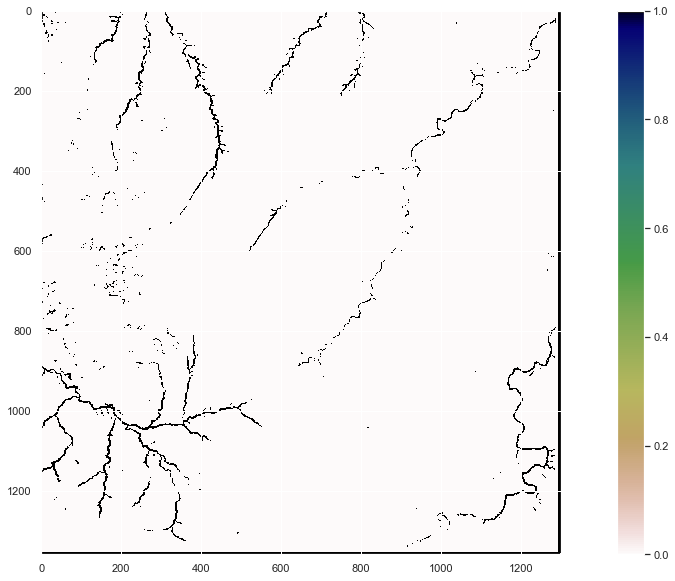

In [15]:
plt.figure(figsize=(20,10));
plt.imshow(dfme_copy, cmap="gist_earth_r");
plt.colorbar();

# Define drainage network for minimum gully head catchment area

In [16]:
min_drainage = np.copy(catchment_area)
min_drainage[min_drainage < threshold_minimum_drainage] = 0

# Define main drainage lines

In [17]:
main_drainage_lines = np.copy(catchment_area)
main_drainage_lines[main_drainage_lines < threshold_main_drainage] = 0

# Visualise drainage lines

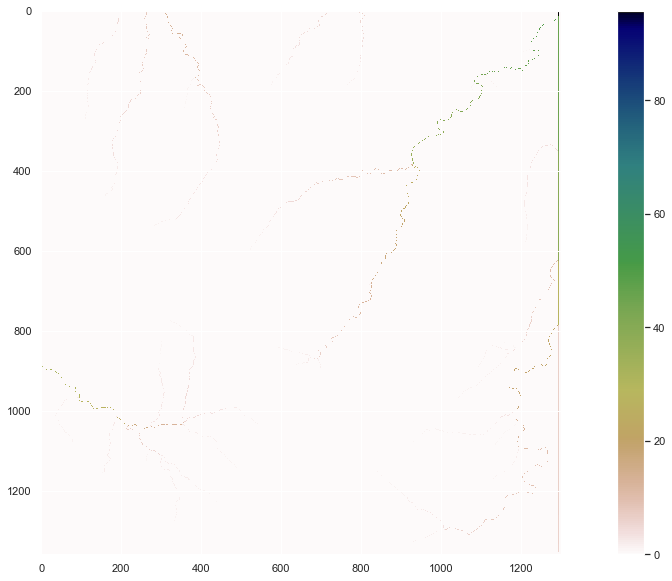

In [18]:
plt.figure(figsize=(20,10));
plt.imshow(main_drainage_lines, cmap="gist_earth_r");
plt.colorbar();

### Tag all provisional channel heads with a new value to search for in subsequent steps

In [19]:
def ghFilterTrim(gully_heads):
    """Tag provisional gully heads with some value (1) so that their location can be found in later steps. """
    surrounding_nodes_list = [];
    for i in range(0, num_values):
        if i != central_value:
            surrounding_nodes_list.append(gully_heads[i])
    
    surrounding_nodes_array = np.array(surrounding_nodes_list)
    non_zero_values = surrounding_nodes_array[surrounding_nodes_array > 0]
    if non_zero_values.size == 0:
        new_value = 0  
    else:
        if gully_heads[central_value] > 0 and np.min(non_zero_values) > gully_heads[central_value]:
            new_value = 1
        else:
            new_value = gully_heads[central_value]

    return new_value

In [20]:
shape = 3
central_value = find_median_value(rectangleWindow(shape, shape))
num_values = number_of_values(rectangleWindow(shape, shape))

provisional_channel_heads = generic_filter(main_drainage_lines, 
                            ghFilterTrim, footprint= rectangleWindow(shape,shape), mode='constant');

### Isolate provisional channel heads. Threshold here must be same as in the 'ghFilterTrim' function above ('new_value').

In [21]:
provisional_channel_heads[provisional_channel_heads>1] = 0
provisional_channel_heads[provisional_channel_heads<1] = 0

### Find index positions of prvisional channel heads.

In [22]:
channel_head_index_positions = np.where(provisional_channel_heads == 1)

In [23]:
for i in range(0, channel_head_index_positions[0].shape[0]):
    print(i)
    p1 = channel_head_index_positions[0][i]
    p2 = channel_head_index_positions[1][i]
    print(p1, '', p2)
    print(provisional_channel_heads[p1,p2])

0
104  1204
1.0
1
187  763
1.0
2
193  387
1.0
3
193  574
1.0
4
198  1144
1.0
5
199  1079
1.0
6
245  358
1.0
7
277  110
1.0
8
463  161
1.0
9
518  894
1.0
10
523  336
1.0
11
539  282
1.0
12
578  1211
1.0
13
600  522
1.0
14
692  818
1.0
15
713  1247
1.0
16
770  316
1.0
17
811  382
1.0
18
828  299
1.0
19
828  1154
1.0
20
842  592
1.0
21
888  635
1.0
22
895  1091
1.0
23
904  699
1.0
24
970  1042
1.0
25
1039  548
1.0
26
1080  929
1.0
27
1081  77
1.0
28
1089  1133
1.0
29
1099  1183
1.0
30
1127  262
1.0
31
1147  490
1.0
32
1151  827
1.0
33
1154  148
1.0
34
1156  159
1.0
35
1177  1128
1.0
36
1230  440
1.0
37
1289  326
1.0
38
1328  931
1.0
39
1355  159
1.0


### Extend only the main drainage lines up to the minimum gully head catchment area threshold 

In [24]:
def extendDrainage(trim_d, ch_id, tag_val):
    
    """ trim_d == provisional_channel_heads
    ch_id == channel_head_index_positions
    rsf == remove_small_features
    tag_val == value to assign to channel heads"""

    row_size = trim_d.shape[0]
    col_size = trim_d.shape[1]

    # Find the maximum possible drainage line length (assuming they're straight).
    drainage_line_max = np.maximum(trim_d.shape[0], trim_d.shape[1])

    #Upper level loop is for each candidate drainage line.
    for i in range(0, ch_id[0].shape[0]):
        next_row_index = ch_id[0][i]
        next_col_index = ch_id[1][i]
        print('next row:', next_row_index, 'next_col: ', next_col_index)
        if next_row_index == 0 or next_row_index == row_size-1 or next_col_index == 0 or next_col_index == col_size-1:
            pass
        else:
            for j in range(0, drainage_line_max):
                immediate_area = trim_d[next_row_index - 1: next_row_index + 2, next_col_index - 1: next_col_index + 2]
                print('immediate area: ', immediate_area)
                non_zero_values = immediate_area[immediate_area > 0]
                if non_zero_values.size < 3:
                    trim_d[next_row_index, next_col_index] = tag_val
                    break
                else:
                    current_cell_value = immediate_area[1,1]
                    print('current cell: ', current_cell_value)
                    candidate_values = immediate_area[immediate_area < current_cell_value]
                    print('candidates: ', candidate_values)
                    number_of_candidates = candidate_values[candidate_values>0]
                    if number_of_candidates.size == 0:
                        pass
                    else:
                        next_cell = np.max(candidate_values)
                        next_cell_row = np.where(immediate_area == next_cell)[0][0]-1
                        next_cell_col = np.where(immediate_area == next_cell)[1][0]-1
                        next_row_index = next_row_index + next_cell_row
                        next_col_index = next_col_index + next_cell_col
                        print('next_cell_row: ', next_row_index)
                        print('next_cell_col: ', next_col_index)
                        if next_row_index == 0 or next_row_index == row_size-1 or next_col_index == 0 or next_col_index == col_size-1:
                            break
                        else:
                            continue

    trim_d[trim_d != tag_val] = 0
                    
    return trim_d

In [25]:
extend_drainage = extendDrainage(min_drainage, channel_head_index_positions, 1)

next row: 104 next_col:  1204
immediate area:  [[ 0.1998  0.      1.0719]
 [ 0.8688  1.0716  0.    ]
 [ 0.      0.      0.    ]]
current cell:  1.0716
candidates:  [ 0.1998  0.      0.8688  0.      0.      0.      0.    ]
next_cell_row:  104
next_cell_col:  1203
immediate area:  [[ 0.1963  0.1998  0.    ]
 [ 0.      0.8688  1.0716]
 [ 0.8686  0.      0.    ]]
current cell:  0.8688
candidates:  [ 0.1963  0.1998  0.      0.      0.8686  0.      0.    ]
next_cell_row:  105
next_cell_col:  1202
immediate area:  [[ 0.      0.      0.8688]
 [ 0.8681  0.8686  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.8686
candidates:  [ 0.      0.      0.8681  0.      0.      0.      0.    ]
next_cell_row:  105
next_cell_col:  1201
immediate area:  [[ 0.      0.      0.    ]
 [ 0.8664  0.8681  0.8686]
 [ 0.      0.      0.    ]]
current cell:  0.8681
candidates:  [ 0.      0.      0.      0.8664  0.      0.      0.    ]
next_cell_row:  105
next_cell_col:  1200
immediate area:  [[ 0.      0.      0.

 [ 0.      0.8179  0.    ]]
current cell:  0.8197
candidates:  [ 0.      0.      0.      0.      0.      0.8179  0.    ]
next_cell_row:  194
next_cell_col:  761
immediate area:  [[ 0.      0.8197  0.    ]
 [ 0.      0.8179  0.    ]
 [ 0.8168  0.      0.    ]]
current cell:  0.8179
candidates:  [ 0.      0.      0.      0.      0.8168  0.      0.    ]
next_cell_row:  195
next_cell_col:  760
immediate area:  [[ 0.      0.      0.8179]
 [ 0.      0.8168  0.    ]
 [ 0.8159  0.      0.    ]]
current cell:  0.8168
candidates:  [ 0.      0.      0.      0.      0.8159  0.      0.    ]
next_cell_row:  196
next_cell_col:  759
immediate area:  [[ 0.      0.      0.8168]
 [ 0.      0.8159  0.    ]
 [ 0.8143  0.      0.    ]]
current cell:  0.8159
candidates:  [ 0.      0.      0.      0.      0.8143  0.      0.    ]
next_cell_row:  197
next_cell_col:  758
immediate area:  [[ 0.      0.      0.8159]
 [ 0.      0.8143  0.    ]
 [ 0.8107  0.      0.    ]]
current cell:  0.8143
candidates:  [ 0.     

 [ 0.      0.3196  0.    ]]
current cell:  0.3197
candidates:  [ 0.      0.      0.      0.      0.      0.3196  0.    ]
next_cell_row:  221
next_cell_col:  383
immediate area:  [[ 0.      0.3197  0.    ]
 [ 0.      0.3196  0.    ]
 [ 0.      0.3195  0.    ]]
current cell:  0.3196
candidates:  [ 0.      0.      0.      0.      0.      0.3195  0.    ]
next_cell_row:  222
next_cell_col:  383
immediate area:  [[ 0.      0.3196  0.    ]
 [ 0.      0.3195  0.    ]
 [ 0.      0.3194  0.    ]]
current cell:  0.3195
candidates:  [ 0.      0.      0.      0.      0.      0.3194  0.    ]
next_cell_row:  223
next_cell_col:  383
immediate area:  [[ 0.      0.3195  0.    ]
 [ 0.      0.3194  0.    ]
 [ 0.3192  0.      0.    ]]
current cell:  0.3194
candidates:  [ 0.      0.      0.      0.      0.3192  0.      0.    ]
next_cell_row:  224
next_cell_col:  382
immediate area:  [[ 0.      0.      0.3194]
 [ 0.      0.3192  0.    ]
 [ 0.      0.3188  0.    ]]
current cell:  0.3192
candidates:  [ 0.     

candidates:  [ 0.      0.      0.      0.      0.      0.      0.2929]
next_cell_row:  269
next_cell_col:  380
immediate area:  [[ 0.2932  0.      0.    ]
 [ 0.      0.2929  0.    ]
 [ 0.      0.2928  0.    ]]
current cell:  0.2929
candidates:  [ 0.      0.      0.      0.      0.      0.2928  0.    ]
next_cell_row:  270
next_cell_col:  380
immediate area:  [[ 0.      0.2929  0.    ]
 [ 0.      0.2928  0.    ]
 [ 0.2918  0.      0.    ]]
current cell:  0.2928
candidates:  [ 0.      0.      0.      0.      0.2918  0.      0.    ]
next_cell_row:  271
next_cell_col:  379
immediate area:  [[ 0.      0.      0.2928]
 [ 0.      0.2918  0.    ]
 [ 0.      0.2916  0.    ]]
current cell:  0.2918
candidates:  [ 0.      0.      0.      0.      0.      0.2916  0.    ]
next_cell_row:  272
next_cell_col:  379
immediate area:  [[ 0.      0.2918  0.    ]
 [ 0.      0.2916  0.    ]
 [ 0.2861  0.      0.    ]]
current cell:  0.2916
candidates:  [ 0.      0.      0.      0.      0.2861  0.      0.    ]
n

candidates:  [ 0.      0.      0.      0.      0.      0.2478  0.    ]
next_cell_row:  315
next_cell_col:  379
immediate area:  [[ 0.      0.248   0.    ]
 [ 0.      0.2478  0.    ]
 [ 0.      0.      0.2477]]
current cell:  0.2478
candidates:  [ 0.      0.      0.      0.      0.      0.      0.2477]
next_cell_row:  316
next_cell_col:  380
immediate area:  [[ 0.2478  0.      0.    ]
 [ 0.      0.2477  0.    ]
 [ 0.      0.2475  0.    ]]
current cell:  0.2477
candidates:  [ 0.      0.      0.      0.      0.      0.2475  0.    ]
next_cell_row:  317
next_cell_col:  380
immediate area:  [[ 0.      0.2477  0.    ]
 [ 0.      0.2475  0.    ]
 [ 0.      0.      0.2473]]
current cell:  0.2475
candidates:  [ 0.      0.      0.      0.      0.      0.      0.2473]
next_cell_row:  318
next_cell_col:  381
immediate area:  [[ 0.2475  0.      0.    ]
 [ 0.      0.2473  0.    ]
 [ 0.2453  0.      0.    ]]
current cell:  0.2473
candidates:  [ 0.      0.      0.      0.      0.2453  0.      0.    ]
n

next_cell_col:  563
immediate area:  [[ 0.      0.6251  0.    ]
 [ 0.1225  0.5022  0.    ]
 [ 0.      0.5021  0.    ]]
current cell:  0.5022
candidates:  [ 0.      0.      0.1225  0.      0.      0.5021  0.    ]
next_cell_row:  210
next_cell_col:  563
immediate area:  [[ 0.1225  0.5022  0.    ]
 [ 0.      0.5021  0.    ]
 [ 0.      0.      0.4943]]
current cell:  0.5021
candidates:  [ 0.1225  0.      0.      0.      0.      0.      0.4943]
next_cell_row:  211
next_cell_col:  564
immediate area:  [[ 0.5021  0.      0.    ]
 [ 0.      0.4943  0.    ]
 [ 0.      0.4937  0.    ]]
current cell:  0.4943
candidates:  [ 0.      0.      0.      0.      0.      0.4937  0.    ]
next_cell_row:  212
next_cell_col:  564
immediate area:  [[ 0.      0.4943  0.    ]
 [ 0.      0.4937  0.    ]
 [ 0.      0.      0.4906]]
current cell:  0.4937
candidates:  [ 0.      0.      0.      0.      0.      0.      0.4906]
next_cell_row:  213
next_cell_col:  565
immediate area:  [[ 0.4937  0.      0.    ]
 [ 0.   

next_cell_col:  568
immediate area:  [[ 0.1833  0.      0.    ]
 [ 0.      0.1831  0.    ]
 [ 0.      0.1829  0.    ]]
current cell:  0.1831
candidates:  [ 0.      0.      0.      0.      0.      0.1829  0.    ]
next_cell_row:  279
next_cell_col:  568
immediate area:  [[ 0.      0.1831  0.    ]
 [ 0.      0.1829  0.    ]
 [ 0.      0.      0.1828]]
current cell:  0.1829
candidates:  [ 0.      0.      0.      0.      0.      0.      0.1828]
next_cell_row:  280
next_cell_col:  569
immediate area:  [[ 0.1829  0.      0.    ]
 [ 0.      0.1828  0.    ]
 [ 0.      0.1821  0.    ]]
current cell:  0.1828
candidates:  [ 0.      0.      0.      0.      0.      0.1821  0.    ]
next_cell_row:  281
next_cell_col:  569
immediate area:  [[ 0.      0.1828  0.    ]
 [ 0.      0.1821  0.    ]
 [ 0.      0.182   0.    ]]
current cell:  0.1821
candidates:  [ 0.     0.     0.     0.     0.     0.182  0.   ]
next_cell_row:  282
next_cell_col:  569
immediate area:  [[ 0.      0.1821  0.    ]
 [ 0.      0.18

candidates:  [ 0.     0.     0.     0.     0.     0.128  0.198]
next_cell_row:  261
next_cell_col:  1152
immediate area:  [[ 0.327   0.      0.    ]
 [ 0.128   0.198   0.    ]
 [ 0.1279  0.      0.1978]]
current cell:  0.198
candidates:  [ 0.      0.      0.128   0.      0.1279  0.      0.1978]
next_cell_row:  262
next_cell_col:  1153
immediate area:  [[ 0.198   0.      0.    ]
 [ 0.      0.1978  0.    ]
 [ 0.      0.      0.1977]]
current cell:  0.1978
candidates:  [ 0.      0.      0.      0.      0.      0.      0.1977]
next_cell_row:  263
next_cell_col:  1154
immediate area:  [[ 0.1978  0.      0.    ]
 [ 0.      0.1977  0.    ]
 [ 0.      0.1976  0.    ]]
current cell:  0.1977
candidates:  [ 0.      0.      0.      0.      0.      0.1976  0.    ]
next_cell_row:  264
next_cell_col:  1154
immediate area:  [[ 0.      0.1977  0.    ]
 [ 0.      0.1976  0.    ]
 [ 0.      0.1974  0.    ]]
current cell:  0.1976
candidates:  [ 0.      0.      0.      0.      0.      0.1974  0.    ]
next_

next_cell_col:  1170
immediate area:  [[ 0.      0.1266  0.    ]
 [ 0.      0.1265  0.    ]
 [ 0.1253  0.      0.    ]]
current cell:  0.1265
candidates:  [ 0.      0.      0.      0.      0.1253  0.      0.    ]
next_cell_row:  316
next_cell_col:  1169
immediate area:  [[ 0.      0.      0.1265]
 [ 0.      0.1253  0.    ]
 [ 0.1252  0.      0.    ]]
current cell:  0.1253
candidates:  [ 0.      0.      0.      0.      0.1252  0.      0.    ]
next_cell_row:  317
next_cell_col:  1168
immediate area:  [[ 0.      0.      0.1253]
 [ 0.      0.1252  0.    ]
 [ 0.      0.1246  0.    ]]
current cell:  0.1252
candidates:  [ 0.      0.      0.      0.      0.      0.1246  0.    ]
next_cell_row:  318
next_cell_col:  1168
immediate area:  [[ 0.      0.1252  0.    ]
 [ 0.      0.1246  0.    ]
 [ 0.      0.1211  0.    ]]
current cell:  0.1246
candidates:  [ 0.      0.      0.      0.      0.      0.1211  0.    ]
next_cell_row:  319
next_cell_col:  1168
immediate area:  [[ 0.      0.1246  0.    ]
 [ 

 [ 0.      0.      0.    ]]
current cell:  0.3584
candidates:  [ 0.      0.      0.      0.3582  0.      0.      0.    ]
next_cell_row:  204
next_cell_col:  1044
immediate area:  [[ 0.3581  0.      0.    ]
 [ 0.      0.3582  0.3584]
 [ 0.      0.      0.    ]]
current cell:  0.3582
candidates:  [ 0.3581  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  203
next_cell_col:  1043
immediate area:  [[ 0.      0.      0.    ]
 [ 0.358   0.3581  0.    ]
 [ 0.      0.      0.3582]]
current cell:  0.3581
candidates:  [ 0.     0.     0.     0.358  0.     0.     0.   ]
next_cell_row:  203
next_cell_col:  1042
immediate area:  [[ 0.      0.      0.    ]
 [ 0.3578  0.358   0.3581]
 [ 0.      0.      0.    ]]
current cell:  0.358
candidates:  [ 0.      0.      0.      0.3578  0.      0.      0.    ]
next_cell_row:  203
next_cell_col:  1041
immediate area:  [[ 0.3576  0.      0.    ]
 [ 0.      0.3578  0.358 ]
 [ 0.      0.      0.    ]]
current cell:  0.3578
candidates:  [ 0.3576  0. 

next_cell_col:  350
immediate area:  [[ 0.      0.6307  0.    ]
 [ 0.      0.6304  0.    ]
 [ 0.6299  0.      0.    ]]
current cell:  0.6304
candidates:  [ 0.      0.      0.      0.      0.6299  0.      0.    ]
next_cell_row:  270
next_cell_col:  349
immediate area:  [[ 0.      0.      0.6304]
 [ 0.      0.6299  0.    ]
 [ 0.      0.6276  0.    ]]
current cell:  0.6299
candidates:  [ 0.      0.      0.      0.      0.      0.6276  0.    ]
next_cell_row:  271
next_cell_col:  349
immediate area:  [[ 0.      0.6299  0.    ]
 [ 0.      0.6276  0.    ]
 [ 0.      0.      0.6271]]
current cell:  0.6276
candidates:  [ 0.      0.      0.      0.      0.      0.      0.6271]
next_cell_row:  272
next_cell_col:  350
immediate area:  [[ 0.6276  0.      0.    ]
 [ 0.      0.6271  0.    ]
 [ 0.      0.6263  0.    ]]
current cell:  0.6271
candidates:  [ 0.      0.      0.      0.      0.      0.6263  0.    ]
next_cell_row:  273
next_cell_col:  350
immediate area:  [[ 0.      0.6271  0.    ]
 [ 0.   

immediate area:  [[ 0.      0.3244  0.    ]
 [ 0.      0.3243  0.    ]
 [ 0.3241  0.      0.    ]]
current cell:  0.3243
candidates:  [ 0.      0.      0.      0.      0.3241  0.      0.    ]
next_cell_row:  305
next_cell_col:  340
immediate area:  [[ 0.      0.      0.3243]
 [ 0.      0.3241  0.    ]
 [ 0.      0.3228  0.    ]]
current cell:  0.3241
candidates:  [ 0.      0.      0.      0.      0.      0.3228  0.    ]
next_cell_row:  306
next_cell_col:  340
immediate area:  [[ 0.      0.3241  0.    ]
 [ 0.      0.3228  0.    ]
 [ 0.      0.3225  0.    ]]
current cell:  0.3228
candidates:  [ 0.      0.      0.      0.      0.      0.3225  0.    ]
next_cell_row:  307
next_cell_col:  340
immediate area:  [[ 0.      0.3228  0.    ]
 [ 0.      0.3225  0.    ]
 [ 0.      0.3224  0.    ]]
current cell:  0.3225
candidates:  [ 0.      0.      0.      0.      0.      0.3224  0.    ]
next_cell_row:  308
next_cell_col:  340
immediate area:  [[ 0.      0.3225  0.    ]
 [ 0.      0.3224  0.    ]
 

immediate area:  [[ 0.      0.257   0.    ]
 [ 0.      0.2569  0.    ]
 [ 0.      0.2568  0.    ]]
current cell:  0.2569
candidates:  [ 0.      0.      0.      0.      0.      0.2568  0.    ]
next_cell_row:  356
next_cell_col:  326
immediate area:  [[ 0.      0.2569  0.    ]
 [ 0.      0.2568  0.    ]
 [ 0.2567  0.      0.    ]]
current cell:  0.2568
candidates:  [ 0.      0.      0.      0.      0.2567  0.      0.    ]
next_cell_row:  357
next_cell_col:  325
immediate area:  [[ 0.      0.      0.2568]
 [ 0.      0.2567  0.    ]
 [ 0.      0.      0.2561]]
current cell:  0.2567
candidates:  [ 0.      0.      0.      0.      0.      0.      0.2561]
next_cell_row:  358
next_cell_col:  326
immediate area:  [[ 0.2567  0.      0.    ]
 [ 0.      0.2561  0.    ]
 [ 0.      0.256   0.    ]]
current cell:  0.2561
candidates:  [ 0.     0.     0.     0.     0.     0.256  0.   ]
next_cell_row:  359
next_cell_col:  326
immediate area:  [[ 0.      0.2561  0.    ]
 [ 0.      0.256   0.    ]
 [ 0.   

current cell:  0.7484
candidates:  [ 0.      0.      0.      0.      0.      0.3124  0.4359]
next_cell_row:  297
next_cell_col:  114
immediate area:  [[ 0.7484  0.      0.    ]
 [ 0.3124  0.4359  0.    ]
 [ 0.      0.4358  0.    ]]
current cell:  0.4359
candidates:  [ 0.      0.      0.3124  0.      0.      0.4358  0.    ]
next_cell_row:  298
next_cell_col:  114
immediate area:  [[ 0.3124  0.4359  0.    ]
 [ 0.      0.4358  0.    ]
 [ 0.      0.3986  0.    ]]
current cell:  0.4358
candidates:  [ 0.3124  0.      0.      0.      0.      0.3986  0.    ]
next_cell_row:  299
next_cell_col:  114
immediate area:  [[ 0.      0.4358  0.    ]
 [ 0.      0.3986  0.    ]
 [ 0.      0.      0.397 ]]
current cell:  0.3986
candidates:  [ 0.     0.     0.     0.     0.     0.     0.397]
next_cell_row:  300
next_cell_col:  115
immediate area:  [[ 0.3986  0.      0.    ]
 [ 0.      0.397   0.    ]
 [ 0.      0.3966  0.    ]]
current cell:  0.397
candidates:  [ 0.      0.      0.      0.      0.      0.3

immediate area:  [[ 0.2317  0.      0.    ]
 [ 0.      0.2296  0.    ]
 [ 0.      0.2294  0.    ]]
current cell:  0.2296
candidates:  [ 0.      0.      0.      0.      0.      0.2294  0.    ]
next_cell_row:  339
next_cell_col:  122
immediate area:  [[ 0.      0.2296  0.    ]
 [ 0.      0.2294  0.    ]
 [ 0.      0.2291  0.    ]]
current cell:  0.2294
candidates:  [ 0.      0.      0.      0.      0.      0.2291  0.    ]
next_cell_row:  340
next_cell_col:  122
immediate area:  [[ 0.      0.2294  0.    ]
 [ 0.      0.2291  0.    ]
 [ 0.      0.      0.228 ]]
current cell:  0.2291
candidates:  [ 0.     0.     0.     0.     0.     0.     0.228]
next_cell_row:  341
next_cell_col:  123
immediate area:  [[ 0.2291  0.      0.    ]
 [ 0.      0.228   0.    ]
 [ 0.      0.2276  0.    ]]
current cell:  0.228
candidates:  [ 0.      0.      0.      0.      0.      0.2276  0.    ]
next_cell_row:  342
next_cell_col:  123
immediate area:  [[ 0.      0.228   0.    ]
 [ 0.      0.2276  0.    ]
 [ 0.    

 [ 0.5464  0.      0.    ]]
current cell:  0.5465
candidates:  [ 0.      0.      0.      0.      0.5464  0.      0.    ]
next_cell_row:  501
next_cell_col:  150
immediate area:  [[ 0.      0.      0.5465]
 [ 0.      0.5464  0.    ]
 [ 0.5463  0.      0.    ]]
current cell:  0.5464
candidates:  [ 0.      0.      0.      0.      0.5463  0.      0.    ]
next_cell_row:  502
next_cell_col:  149
immediate area:  [[ 0.      0.      0.5464]
 [ 0.5448  0.5463  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.5463
candidates:  [ 0.      0.      0.5448  0.      0.      0.      0.    ]
next_cell_row:  502
next_cell_col:  148
immediate area:  [[ 0.      0.      0.    ]
 [ 0.5445  0.5448  0.5463]
 [ 0.      0.      0.    ]]
current cell:  0.5448
candidates:  [ 0.      0.      0.      0.5445  0.      0.      0.    ]
next_cell_row:  502
next_cell_col:  147
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.5445  0.5448]
 [ 0.5402  0.      0.    ]]
current cell:  0.5445
candidates:  [ 0.     

next_cell_row:  525
next_cell_col:  114
immediate area:  [[ 0.      0.      0.258 ]
 [ 0.      0.2575  0.    ]
 [ 0.      0.2501  0.    ]]
current cell:  0.2575
candidates:  [ 0.      0.      0.      0.      0.      0.2501  0.    ]
next_cell_row:  526
next_cell_col:  114
immediate area:  [[ 0.      0.2575  0.    ]
 [ 0.      0.2501  0.    ]
 [ 0.2497  0.      0.    ]]
current cell:  0.2501
candidates:  [ 0.      0.      0.      0.      0.2497  0.      0.    ]
next_cell_row:  527
next_cell_col:  113
immediate area:  [[ 0.      0.      0.2501]
 [ 0.      0.2497  0.    ]
 [ 0.2116  0.      0.    ]]
current cell:  0.2497
candidates:  [ 0.      0.      0.      0.      0.2116  0.      0.    ]
next_cell_row:  528
next_cell_col:  112
immediate area:  [[ 0.      0.      0.2497]
 [ 0.      0.2116  0.    ]
 [ 0.2115  0.      0.    ]]
current cell:  0.2116
candidates:  [ 0.      0.      0.      0.      0.2115  0.      0.    ]
next_cell_row:  529
next_cell_col:  111
immediate area:  [[ 0.      0.  

next_cell_col:  881
immediate area:  [[ 0.      0.4596  0.4597]
 [ 0.1882  0.3701  0.    ]
 [ 0.1816  0.      0.    ]]
current cell:  0.3701
candidates:  [ 0.      0.1882  0.      0.1816  0.      0.    ]
next_cell_row:  538
next_cell_col:  880
immediate area:  [[ 0.      0.      0.4596]
 [ 0.1881  0.1882  0.3701]
 [ 0.      0.1816  0.    ]]
current cell:  0.1882
candidates:  [ 0.      0.      0.1881  0.      0.1816  0.    ]
next_cell_row:  538
next_cell_col:  879
immediate area:  [[ 0.      0.      0.    ]
 [ 0.188   0.1881  0.1882]
 [ 0.      0.      0.1816]]
current cell:  0.1881
candidates:  [ 0.      0.      0.      0.188   0.      0.      0.1816]
next_cell_row:  538
next_cell_col:  878
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1879  0.188   0.1881]
 [ 0.      0.      0.    ]]
current cell:  0.188
candidates:  [ 0.      0.      0.      0.1879  0.      0.      0.    ]
next_cell_row:  538
next_cell_col:  877
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.1879  0.188 

next_cell_col:  843
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.1003  0.1007]
 [ 0.      0.      0.    ]]
next row: 523 next_col:  336
immediate area:  [[ 0.      1.6871  2.6895]
 [ 0.9428  1.001   0.    ]
 [ 0.      0.      0.    ]]
current cell:  1.001
candidates:  [ 0.      0.9428  0.      0.      0.      0.    ]
next_cell_row:  523
next_cell_col:  335
immediate area:  [[ 0.      0.      1.6871]
 [ 0.      0.9428  1.001 ]
 [ 0.9426  0.      0.    ]]
current cell:  0.9428
candidates:  [ 0.      0.      0.      0.9426  0.      0.    ]
next_cell_row:  524
next_cell_col:  334
immediate area:  [[ 0.      0.      0.9428]
 [ 0.9203  0.9426  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.9426
candidates:  [ 0.      0.      0.9203  0.      0.      0.      0.    ]
next_cell_row:  524
next_cell_col:  333
immediate area:  [[ 0.      0.      0.    ]
 [ 0.9202  0.9203  0.9426]
 [ 0.9183  0.      0.    ]]
current cell:  0.9203
candidates:  [ 0.      0.      0.      0.9202  0.918

candidates:  [ 0.      0.      0.      0.      0.1125  0.      0.    ]
next_cell_row:  563
next_cell_col:  316
immediate area:  [[ 0.      0.      0.2125]
 [ 0.      0.1125  0.    ]
 [ 0.1119  0.      0.    ]]
current cell:  0.1125
candidates:  [ 0.      0.      0.      0.      0.1119  0.      0.    ]
next_cell_row:  564
next_cell_col:  315
immediate area:  [[ 0.      0.      0.1125]
 [ 0.      0.1119  0.    ]
 [ 0.1115  0.      0.    ]]
current cell:  0.1119
candidates:  [ 0.      0.      0.      0.      0.1115  0.      0.    ]
next_cell_row:  565
next_cell_col:  314
immediate area:  [[ 0.      0.      0.1119]
 [ 0.      0.1115  0.    ]
 [ 0.1097  0.      0.    ]]
current cell:  0.1115
candidates:  [ 0.      0.      0.      0.      0.1097  0.      0.    ]
next_cell_row:  566
next_cell_col:  313
immediate area:  [[ 0.      0.      0.1115]
 [ 0.      0.1097  0.    ]
 [ 0.      0.1096  0.    ]]
current cell:  0.1097
candidates:  [ 0.      0.      0.      0.      0.      0.1096  0.    ]
n

candidates:  [ 0.      0.      0.      0.      0.7508  0.      0.    ]
next_cell_row:  575
next_cell_col:  250
immediate area:  [[ 0.      0.      0.7509]
 [ 0.7504  0.7508  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.7508
candidates:  [ 0.      0.      0.7504  0.      0.      0.      0.    ]
next_cell_row:  575
next_cell_col:  249
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.7504  0.7508]
 [ 0.7503  0.      0.    ]]
current cell:  0.7504
candidates:  [ 0.      0.      0.      0.      0.7503  0.      0.    ]
next_cell_row:  576
next_cell_col:  248
immediate area:  [[ 0.      0.      0.7504]
 [ 0.      0.7503  0.    ]
 [ 0.7502  0.      0.    ]]
current cell:  0.7503
candidates:  [ 0.      0.      0.      0.      0.7502  0.      0.    ]
next_cell_row:  577
next_cell_col:  247
immediate area:  [[ 0.      0.      0.7503]
 [ 0.      0.7502  0.    ]
 [ 0.7501  0.      0.    ]]
current cell:  0.7502
candidates:  [ 0.      0.      0.      0.      0.7501  0.      0.    ]
n

next_cell_col:  202
immediate area:  [[ 0.      0.      0.4761]
 [ 0.      0.4756  0.    ]
 [ 0.      0.4716  0.    ]]
current cell:  0.4756
candidates:  [ 0.      0.      0.      0.      0.      0.4716  0.    ]
next_cell_row:  614
next_cell_col:  202
immediate area:  [[ 0.      0.4756  0.    ]
 [ 0.      0.4716  0.    ]
 [ 0.4689  0.      0.    ]]
current cell:  0.4716
candidates:  [ 0.      0.      0.      0.      0.4689  0.      0.    ]
next_cell_row:  615
next_cell_col:  201
immediate area:  [[ 0.      0.      0.4716]
 [ 0.      0.4689  0.    ]
 [ 0.      0.4669  0.    ]]
current cell:  0.4689
candidates:  [ 0.      0.      0.      0.      0.      0.4669  0.    ]
next_cell_row:  616
next_cell_col:  201
immediate area:  [[ 0.      0.4689  0.    ]
 [ 0.      0.4669  0.    ]
 [ 0.      0.4666  0.    ]]
current cell:  0.4669
candidates:  [ 0.      0.      0.      0.      0.      0.4666  0.    ]
next_cell_row:  617
next_cell_col:  201
immediate area:  [[ 0.      0.4669  0.    ]
 [ 0.   

immediate area:  [[ 0.      0.      0.    ]
 [ 0.1939  0.2469  0.2475]
 [ 0.      0.      0.    ]]
current cell:  0.2469
candidates:  [ 0.      0.      0.      0.1939  0.      0.      0.    ]
next_cell_row:  630
next_cell_col:  170
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.1939  0.2469]
 [ 0.1888  0.      0.    ]]
current cell:  0.1939
candidates:  [ 0.      0.      0.      0.      0.1888  0.      0.    ]
next_cell_row:  631
next_cell_col:  169
immediate area:  [[ 0.      0.      0.1939]
 [ 0.1886  0.1888  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1888
candidates:  [ 0.      0.      0.1886  0.      0.      0.      0.    ]
next_cell_row:  631
next_cell_col:  168
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1884  0.1886  0.1888]
 [ 0.      0.      0.    ]]
current cell:  0.1886
candidates:  [ 0.      0.      0.      0.1884  0.      0.      0.    ]
next_cell_row:  631
next_cell_col:  167
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1875  0.1884  0.1886]
 

candidates:  [ 0.      0.      0.      0.      0.5107  0.      0.    ]
next_cell_row:  600
next_cell_col:  1205
immediate area:  [[ 0.      0.      0.5128]
 [ 0.      0.5107  0.    ]
 [ 0.      0.5101  0.    ]]
current cell:  0.5107
candidates:  [ 0.      0.      0.      0.      0.      0.5101  0.    ]
next_cell_row:  601
next_cell_col:  1205
immediate area:  [[ 0.      0.5107  0.    ]
 [ 0.      0.5101  0.    ]
 [ 0.      0.5095  0.    ]]
current cell:  0.5101
candidates:  [ 0.      0.      0.      0.      0.      0.5095  0.    ]
next_cell_row:  602
next_cell_col:  1205
immediate area:  [[ 0.      0.5101  0.    ]
 [ 0.      0.5095  0.    ]
 [ 0.      0.5023  0.    ]]
current cell:  0.5095
candidates:  [ 0.      0.      0.      0.      0.      0.5023  0.    ]
next_cell_row:  603
next_cell_col:  1205
immediate area:  [[ 0.      0.5095  0.    ]
 [ 0.      0.5023  0.    ]
 [ 0.      0.5008  0.    ]]
current cell:  0.5023
candidates:  [ 0.      0.      0.      0.      0.      0.5008  0.   

candidates:  [ 0.      0.      0.      0.      0.1398  0.      0.    ]
next_cell_row:  657
next_cell_col:  1157
immediate area:  [[ 0.      0.      0.173 ]
 [ 0.      0.1398  0.    ]
 [ 0.      0.1365  0.    ]]
current cell:  0.1398
candidates:  [ 0.      0.      0.      0.      0.      0.1365  0.    ]
next_cell_row:  658
next_cell_col:  1157
immediate area:  [[ 0.      0.1398  0.    ]
 [ 0.      0.1365  0.    ]
 [ 0.1364  0.      0.    ]]
current cell:  0.1365
candidates:  [ 0.      0.      0.      0.      0.1364  0.      0.    ]
next_cell_row:  659
next_cell_col:  1156
immediate area:  [[ 0.      0.      0.1365]
 [ 0.      0.1364  0.    ]
 [ 0.1362  0.      0.    ]]
current cell:  0.1364
candidates:  [ 0.      0.      0.      0.      0.1362  0.      0.    ]
next_cell_row:  660
next_cell_col:  1155
immediate area:  [[ 0.      0.      0.1364]
 [ 0.      0.1362  0.    ]
 [ 0.1357  0.      0.    ]]
current cell:  0.1362
candidates:  [ 0.      0.      0.      0.      0.1357  0.      0.   

immediate area:  [[ 0.      0.      0.3666]
 [ 0.3664  0.3665  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.3665
candidates:  [ 0.      0.      0.3664  0.      0.      0.      0.    ]
next_cell_row:  613
next_cell_col:  510
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.3664  0.3665]
 [ 0.3663  0.      0.    ]]
current cell:  0.3664
candidates:  [ 0.      0.      0.      0.      0.3663  0.      0.    ]
next_cell_row:  614
next_cell_col:  509
immediate area:  [[ 0.      0.      0.3664]
 [ 0.      0.3663  0.    ]
 [ 0.      0.3638  0.    ]]
current cell:  0.3663
candidates:  [ 0.      0.      0.      0.      0.      0.3638  0.    ]
next_cell_row:  615
next_cell_col:  509
immediate area:  [[ 0.      0.3663  0.    ]
 [ 0.      0.3638  0.    ]
 [ 0.2572  0.1065  0.    ]]
current cell:  0.3638
candidates:  [ 0.      0.      0.      0.      0.2572  0.1065  0.    ]
next_cell_row:  616
next_cell_col:  508
immediate area:  [[ 0.      0.      0.3638]
 [ 0.      0.2572  0.1065]
 

candidates:  [ 0.      0.      0.      0.      0.      0.3818  0.    ]
next_cell_row:  718
next_cell_col:  808
immediate area:  [[ 0.      0.4117  0.    ]
 [ 0.      0.3818  0.    ]
 [ 0.3815  0.      0.    ]]
current cell:  0.3818
candidates:  [ 0.      0.      0.      0.      0.3815  0.      0.    ]
next_cell_row:  719
next_cell_col:  807
immediate area:  [[ 0.      0.      0.3818]
 [ 0.      0.3815  0.    ]
 [ 0.      0.3809  0.    ]]
current cell:  0.3815
candidates:  [ 0.      0.      0.      0.      0.      0.3809  0.    ]
next_cell_row:  720
next_cell_col:  807
immediate area:  [[ 0.      0.3815  0.    ]
 [ 0.      0.3809  0.    ]
 [ 0.3788  0.3795  0.    ]]
current cell:  0.3809
candidates:  [ 0.      0.      0.      0.      0.3788  0.3795  0.    ]
next_cell_row:  721
next_cell_col:  807
immediate area:  [[ 0.      0.3809  0.    ]
 [ 0.3788  0.3795  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.3795
candidates:  [ 0.      0.      0.3788  0.      0.      0.      0.    ]
n

next_cell_row:  719
next_cell_col:  741
immediate area:  [[ 0.      0.      0.    ]
 [ 0.175   0.1751  0.1752]
 [ 0.      0.      0.    ]]
current cell:  0.1751
candidates:  [ 0.     0.     0.     0.175  0.     0.     0.   ]
next_cell_row:  719
next_cell_col:  740
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1749  0.175   0.1751]
 [ 0.      0.      0.    ]]
current cell:  0.175
candidates:  [ 0.      0.      0.      0.1749  0.      0.      0.    ]
next_cell_row:  719
next_cell_col:  739
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1746  0.1749  0.175 ]
 [ 0.      0.      0.    ]]
current cell:  0.1749
candidates:  [ 0.      0.      0.      0.1746  0.      0.      0.    ]
next_cell_row:  719
next_cell_col:  738
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1745  0.1746  0.1749]
 [ 0.      0.      0.    ]]
current cell:  0.1746
candidates:  [ 0.      0.      0.      0.1745  0.      0.      0.    ]
next_cell_row:  719
next_cell_col:  737
immediate area:  [[ 0.      0.      0.  

next_cell_row:  687
next_cell_col:  1192
immediate area:  [[ 0.      0.      0.    ]
 [ 0.7939  0.794   0.7941]
 [ 0.      0.      0.    ]]
current cell:  0.794
candidates:  [ 0.      0.      0.      0.7939  0.      0.      0.    ]
next_cell_row:  687
next_cell_col:  1191
immediate area:  [[ 0.7937  0.      0.    ]
 [ 0.      0.7939  0.794 ]
 [ 0.      0.      0.    ]]
current cell:  0.7939
candidates:  [ 0.7937  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  686
next_cell_col:  1190
immediate area:  [[ 0.      0.      0.    ]
 [ 0.7934  0.7937  0.    ]
 [ 0.      0.      0.7939]]
current cell:  0.7937
candidates:  [ 0.      0.      0.      0.7934  0.      0.      0.    ]
next_cell_row:  686
next_cell_col:  1189
immediate area:  [[ 0.      0.      0.    ]
 [ 0.7933  0.7934  0.7937]
 [ 0.      0.      0.    ]]
current cell:  0.7934
candidates:  [ 0.      0.      0.      0.7933  0.      0.      0.    ]
next_cell_row:  686
next_cell_col:  1188
immediate area:  [[ 0.      

candidates:  [ 0.      0.      0.      0.1086  0.      0.      0.    ]
next_cell_row:  693
next_cell_col:  1094
immediate area:  [[ 0.1061  0.      0.    ]
 [ 0.      0.1086  0.1091]
 [ 0.      0.      0.    ]]
current cell:  0.1086
candidates:  [ 0.1061  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  692
next_cell_col:  1093
immediate area:  [[ 0.1059  0.      0.    ]
 [ 0.      0.1061  0.    ]
 [ 0.      0.      0.1086]]
current cell:  0.1061
candidates:  [ 0.1059  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  691
next_cell_col:  1092
immediate area:  [[ 0.      0.1058  0.    ]
 [ 0.      0.1059  0.    ]
 [ 0.      0.      0.1061]]
current cell:  0.1059
candidates:  [ 0.      0.1058  0.      0.      0.      0.      0.    ]
next_cell_row:  690
next_cell_col:  1092
immediate area:  [[ 0.      0.1036  0.    ]
 [ 0.      0.1058  0.    ]
 [ 0.      0.1059  0.    ]]
current cell:  0.1058
candidates:  [ 0.      0.1036  0.      0.      0.      0.      0.   

next_cell_row:  723
next_cell_col:  247
immediate area:  [[ 0.7305  0.      0.    ]
 [ 0.      0.731   0.7314]
 [ 0.      0.      0.    ]]
current cell:  0.731
candidates:  [ 0.7305  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  722
next_cell_col:  246
immediate area:  [[ 0.      0.      0.    ]
 [ 0.7277  0.7305  0.    ]
 [ 0.      0.      0.731 ]]
current cell:  0.7305
candidates:  [ 0.      0.      0.      0.7277  0.      0.      0.    ]
next_cell_row:  722
next_cell_col:  245
immediate area:  [[ 0.      0.      0.    ]
 [ 0.7273  0.7277  0.7305]
 [ 0.      0.      0.    ]]
current cell:  0.7277
candidates:  [ 0.      0.      0.      0.7273  0.      0.      0.    ]
next_cell_row:  722
next_cell_col:  244
immediate area:  [[ 0.      0.      0.    ]
 [ 0.7259  0.7273  0.7277]
 [ 0.      0.      0.    ]]
current cell:  0.7273
candidates:  [ 0.      0.      0.      0.7259  0.      0.      0.    ]
next_cell_row:  722
next_cell_col:  243
immediate area:  [[ 0.      0.   

candidates:  [ 0.425  0.     0.     0.     0.     0.     0.   ]
next_cell_row:  713
next_cell_col:  210
immediate area:  [[ 0.      0.      0.    ]
 [ 0.4232  0.425   0.    ]
 [ 0.      0.      0.4265]]
current cell:  0.425
candidates:  [ 0.      0.      0.      0.4232  0.      0.      0.    ]
next_cell_row:  713
next_cell_col:  209
immediate area:  [[ 0.      0.      0.    ]
 [ 0.423   0.4232  0.425 ]
 [ 0.      0.      0.    ]]
current cell:  0.4232
candidates:  [ 0.     0.     0.     0.423  0.     0.     0.   ]
next_cell_row:  713
next_cell_col:  208
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.423   0.4232]
 [ 0.3811  0.      0.    ]]
current cell:  0.423
candidates:  [ 0.      0.      0.      0.      0.3811  0.      0.    ]
next_cell_row:  714
next_cell_col:  207
immediate area:  [[ 0.      0.      0.423 ]
 [ 0.      0.3811  0.    ]
 [ 0.3801  0.      0.    ]]
current cell:  0.3811
candidates:  [ 0.      0.      0.      0.      0.3801  0.      0.    ]
next_cell_row:  7

candidates:  [ 0.      0.      0.5567  0.      0.      0.      0.    ]
next_cell_row:  799
next_cell_col:  387
immediate area:  [[ 0.      0.      0.5564]
 [ 0.      0.5567  0.    ]
 [ 0.557   0.      0.    ]]
current cell:  0.5567
candidates:  [ 0.      0.      0.5564  0.      0.      0.      0.    ]
next_cell_row:  798
next_cell_col:  388
immediate area:  [[ 0.      0.5562  0.    ]
 [ 0.      0.5564  0.    ]
 [ 0.5567  0.      0.    ]]
current cell:  0.5564
candidates:  [ 0.      0.5562  0.      0.      0.      0.      0.    ]
next_cell_row:  797
next_cell_col:  388
immediate area:  [[ 0.      0.5559  0.    ]
 [ 0.      0.5562  0.    ]
 [ 0.      0.5564  0.    ]]
current cell:  0.5562
candidates:  [ 0.      0.5559  0.      0.      0.      0.      0.    ]
next_cell_row:  796
next_cell_col:  388
immediate area:  [[ 0.      0.      0.5557]
 [ 0.      0.5559  0.    ]
 [ 0.      0.5562  0.    ]]
current cell:  0.5559
candidates:  [ 0.      0.      0.5557  0.      0.      0.      0.    ]
n

immediate area:  [[ 0.      0.      0.5346]
 [ 0.      0.5348  0.    ]
 [ 0.      0.5349  0.    ]]
current cell:  0.5348
candidates:  [ 0.      0.      0.5346  0.      0.      0.      0.    ]
next_cell_row:  764
next_cell_col:  405
immediate area:  [[ 0.      0.5344  0.    ]
 [ 0.      0.5346  0.    ]
 [ 0.5348  0.      0.    ]]
current cell:  0.5346
candidates:  [ 0.      0.5344  0.      0.      0.      0.      0.    ]
next_cell_row:  763
next_cell_col:  405
immediate area:  [[ 0.      0.      0.448 ]
 [ 0.      0.5344  0.    ]
 [ 0.      0.5346  0.    ]]
current cell:  0.5344
candidates:  [ 0.     0.     0.448  0.     0.     0.     0.   ]
next_cell_row:  762
next_cell_col:  406
immediate area:  [[ 0.      0.4479  0.    ]
 [ 0.      0.448   0.    ]
 [ 0.5344  0.      0.    ]]
current cell:  0.448
candidates:  [ 0.      0.4479  0.      0.      0.      0.      0.    ]
next_cell_row:  761
next_cell_col:  406
immediate area:  [[ 0.4478  0.      0.    ]
 [ 0.      0.4479  0.    ]
 [ 0.    

next_cell_row:  712
next_cell_col:  372
immediate area:  [[ 0.4231  0.      0.    ]
 [ 0.      0.4232  0.    ]
 [ 0.      0.      0.4237]]
current cell:  0.4232
candidates:  [ 0.4231  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  711
next_cell_col:  371
immediate area:  [[ 0.4229  0.      0.    ]
 [ 0.      0.4231  0.    ]
 [ 0.      0.      0.4232]]
current cell:  0.4231
candidates:  [ 0.4229  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  710
next_cell_col:  370
immediate area:  [[ 0.      0.      0.    ]
 [ 0.4227  0.4229  0.    ]
 [ 0.      0.      0.4231]]
current cell:  0.4229
candidates:  [ 0.      0.      0.      0.4227  0.      0.      0.    ]
next_cell_row:  710
next_cell_col:  369
immediate area:  [[ 0.4226  0.      0.    ]
 [ 0.      0.4227  0.4229]
 [ 0.      0.      0.    ]]
current cell:  0.4227
candidates:  [ 0.4226  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  709
next_cell_col:  368
immediate area:  [[ 0.4225  0.  

immediate area:  [[ 0.6284  0.      0.    ]
 [ 0.      0.6285  0.6287]
 [ 0.      0.      0.    ]]
current cell:  0.6285
candidates:  [ 0.6284  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  803
next_cell_col:  278
immediate area:  [[ 0.6274  0.      0.    ]
 [ 0.      0.6284  0.    ]
 [ 0.      0.      0.6285]]
current cell:  0.6284
candidates:  [ 0.6274  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  802
next_cell_col:  277
immediate area:  [[ 0.6272  0.      0.    ]
 [ 0.      0.6274  0.    ]
 [ 0.      0.      0.6284]]
current cell:  0.6274
candidates:  [ 0.6272  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  801
next_cell_col:  276
immediate area:  [[ 0.627   0.      0.    ]
 [ 0.      0.6272  0.    ]
 [ 0.      0.      0.6274]]
current cell:  0.6272
candidates:  [ 0.627  0.     0.     0.     0.     0.     0.   ]
next_cell_row:  800
next_cell_col:  275
immediate area:  [[ 0.6268  0.      0.    ]
 [ 0.      0.627   0.    ]
 [ 0.   

candidates:  [ 0.5714  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  772
next_cell_col:  249
immediate area:  [[ 0.      0.      0.    ]
 [ 0.571   0.5714  0.    ]
 [ 0.      0.      0.5716]]
current cell:  0.5714
candidates:  [ 0.     0.     0.     0.571  0.     0.     0.   ]
next_cell_row:  772
next_cell_col:  248
immediate area:  [[ 0.      0.      0.    ]
 [ 0.5709  0.571   0.5714]
 [ 0.      0.      0.    ]]
current cell:  0.571
candidates:  [ 0.      0.      0.      0.5709  0.      0.      0.    ]
next_cell_row:  772
next_cell_col:  247
immediate area:  [[ 0.      0.      0.    ]
 [ 0.5706  0.5709  0.571 ]
 [ 0.      0.      0.    ]]
current cell:  0.5709
candidates:  [ 0.      0.      0.      0.5706  0.      0.      0.    ]
next_cell_row:  772
next_cell_col:  246
immediate area:  [[ 0.57    0.      0.    ]
 [ 0.      0.5706  0.5709]
 [ 0.      0.      0.    ]]
current cell:  0.5706
candidates:  [ 0.57  0.    0.    0.    0.    0.    0.  ]
next_cell_row:  771
nex

candidates:  [ 0.9701  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  825
next_cell_col:  1132
immediate area:  [[ 0.      0.1132  0.    ]
 [ 0.8568  0.9701  0.    ]
 [ 0.      0.      0.9705]]
current cell:  0.9701
candidates:  [ 0.      0.1132  0.      0.8568  0.      0.      0.    ]
next_cell_row:  825
next_cell_col:  1131
immediate area:  [[ 0.8565  0.      0.1132]
 [ 0.      0.8568  0.9701]
 [ 0.      0.      0.    ]]
current cell:  0.8568
candidates:  [ 0.8565  0.      0.1132  0.      0.      0.      0.    ]
next_cell_row:  824
next_cell_col:  1130
immediate area:  [[ 0.      0.      0.    ]
 [ 0.8556  0.8565  0.    ]
 [ 0.      0.      0.8568]]
current cell:  0.8565
candidates:  [ 0.      0.      0.      0.8556  0.      0.      0.    ]
next_cell_row:  824
next_cell_col:  1129
immediate area:  [[ 0.      0.      0.    ]
 [ 0.8555  0.8556  0.8565]
 [ 0.      0.      0.    ]]
current cell:  0.8556
candidates:  [ 0.      0.      0.      0.8555  0.      0.      0.   

candidates:  [ 0.      0.      0.      0.      0.5352  0.      0.    ]
next_cell_row:  816
next_cell_col:  1049
immediate area:  [[ 0.      0.      0.5353]
 [ 0.      0.5352  0.    ]
 [ 0.      0.53    0.    ]]
current cell:  0.5352
candidates:  [ 0.    0.    0.    0.    0.    0.53  0.  ]
next_cell_row:  817
next_cell_col:  1049
immediate area:  [[ 0.      0.5352  0.    ]
 [ 0.      0.53    0.    ]
 [ 0.5298  0.      0.    ]]
current cell:  0.53
candidates:  [ 0.      0.      0.      0.      0.5298  0.      0.    ]
next_cell_row:  818
next_cell_col:  1048
immediate area:  [[ 0.      0.      0.53  ]
 [ 0.      0.5298  0.    ]
 [ 0.5296  0.      0.    ]]
current cell:  0.5298
candidates:  [ 0.      0.      0.      0.      0.5296  0.      0.    ]
next_cell_row:  819
next_cell_col:  1047
immediate area:  [[ 0.      0.      0.5298]
 [ 0.      0.5296  0.    ]
 [ 0.5291  0.      0.    ]]
current cell:  0.5296
candidates:  [ 0.      0.      0.      0.      0.5291  0.      0.    ]
next_cell_row

candidates:  [ 0.      0.      0.      0.1007  0.      0.      0.    ]
next_cell_row:  819
next_cell_col:  524
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1006  0.1007  0.1014]
 [ 0.      0.      0.    ]]
current cell:  0.1007
candidates:  [ 0.      0.      0.      0.1006  0.      0.      0.    ]
next_cell_row:  819
next_cell_col:  523
immediate area:  [[ 0.1004  0.      0.    ]
 [ 0.      0.1006  0.1007]
 [ 0.      0.      0.    ]]
current cell:  0.1006
candidates:  [ 0.1004  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  818
next_cell_col:  522
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1003  0.1004  0.    ]
 [ 0.      0.      0.1006]]
current cell:  0.1004
candidates:  [ 0.      0.      0.      0.1003  0.      0.      0.    ]
next_cell_row:  818
next_cell_col:  521
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1002  0.1003  0.1004]
 [ 0.      0.      0.    ]]
current cell:  0.1003
candidates:  [ 0.      0.      0.      0.1002  0.      0.      0.    ]
n

 [ 0.      0.418   0.    ]]
current cell:  0.4176
candidates:  [ 0.4173  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  896
next_cell_col:  605
immediate area:  [[ 0.4171  0.      0.    ]
 [ 0.      0.4173  0.    ]
 [ 0.      0.      0.4176]]
current cell:  0.4173
candidates:  [ 0.4171  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  895
next_cell_col:  604
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.4171  0.    ]
 [ 0.4169  0.      0.4173]]
current cell:  0.4171
candidates:  [ 0.      0.      0.      0.      0.      0.4169  0.    ]
next_cell_row:  896
next_cell_col:  603
immediate area:  [[ 0.4167  0.      0.4171]
 [ 0.      0.4169  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.4169
candidates:  [ 0.4167  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  895
next_cell_col:  602
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.4167  0.    ]
 [ 0.414   0.      0.4169]]
current cell:  0.4167
candidates:  [ 0.     

next_cell_col:  547
immediate area:  [[ 0.3488  0.      0.3491]
 [ 0.      0.3489  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.3489
candidates:  [ 0.3488  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  898
next_cell_col:  546
immediate area:  [[ 0.3485  0.      0.    ]
 [ 0.      0.3488  0.    ]
 [ 0.      0.      0.3489]]
current cell:  0.3488
candidates:  [ 0.3485  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  897
next_cell_col:  545
immediate area:  [[ 0.3481  0.      0.    ]
 [ 0.      0.3485  0.    ]
 [ 0.      0.      0.3488]]
current cell:  0.3485
candidates:  [ 0.3481  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  896
next_cell_col:  544
immediate area:  [[ 0.      0.      0.    ]
 [ 0.3362  0.3481  0.    ]
 [ 0.      0.      0.3485]]
current cell:  0.3481
candidates:  [ 0.      0.      0.      0.3362  0.      0.      0.    ]
next_cell_row:  896
next_cell_col:  543
immediate area:  [[ 0.      0.      0.    ]
 [ 0.336

current cell:  0.6497
candidates:  [ 0.      0.      0.      0.      0.      0.6495  0.    ]
next_cell_row:  899
next_cell_col:  1089
immediate area:  [[ 0.      0.6497  0.    ]
 [ 0.      0.6495  0.    ]
 [ 0.      0.6357  0.    ]]
current cell:  0.6495
candidates:  [ 0.      0.      0.      0.      0.      0.6357  0.    ]
next_cell_row:  900
next_cell_col:  1089
immediate area:  [[ 0.      0.6495  0.    ]
 [ 0.      0.6357  0.    ]
 [ 0.6355  0.      0.    ]]
current cell:  0.6357
candidates:  [ 0.      0.      0.      0.      0.6355  0.      0.    ]
next_cell_row:  901
next_cell_col:  1088
immediate area:  [[ 0.      0.      0.6357]
 [ 0.      0.6355  0.    ]
 [ 0.635   0.      0.    ]]
current cell:  0.6355
candidates:  [ 0.     0.     0.     0.     0.635  0.     0.   ]
next_cell_row:  902
next_cell_col:  1087
immediate area:  [[ 0.      0.      0.6355]
 [ 0.      0.635   0.    ]
 [ 0.      0.6329  0.    ]]
current cell:  0.635
candidates:  [ 0.      0.      0.      0.      0.     

next_cell_col:  708
immediate area:  [[ 0.      0.4224  0.    ]
 [ 0.      0.4221  0.    ]
 [ 0.      0.4168  0.    ]]
current cell:  0.4221
candidates:  [ 0.      0.      0.      0.      0.      0.4168  0.    ]
next_cell_row:  939
next_cell_col:  708
immediate area:  [[ 0.      0.4221  0.    ]
 [ 0.      0.4168  0.    ]
 [ 0.      0.4125  0.    ]]
current cell:  0.4168
candidates:  [ 0.      0.      0.      0.      0.      0.4125  0.    ]
next_cell_row:  940
next_cell_col:  708
immediate area:  [[ 0.      0.4168  0.    ]
 [ 0.      0.4125  0.    ]
 [ 0.      0.4043  0.    ]]
current cell:  0.4125
candidates:  [ 0.      0.      0.      0.      0.      0.4043  0.    ]
next_cell_row:  941
next_cell_col:  708
immediate area:  [[ 0.      0.4125  0.    ]
 [ 0.      0.4043  0.    ]
 [ 0.      0.4042  0.    ]]
current cell:  0.4043
candidates:  [ 0.      0.      0.      0.      0.      0.4042  0.    ]
next_cell_row:  942
next_cell_col:  708
immediate area:  [[ 0.      0.4043  0.    ]
 [ 0.   

next_cell_col:  1012
immediate area:  [[ 0.      0.      0.5175]
 [ 0.      0.5013  0.    ]
 [ 0.4403  0.      0.    ]]
current cell:  0.5013
candidates:  [ 0.      0.      0.      0.      0.4403  0.      0.    ]
next_cell_row:  1001
next_cell_col:  1011
immediate area:  [[ 0.      0.      0.5013]
 [ 0.      0.4403  0.    ]
 [ 0.4394  0.      0.    ]]
current cell:  0.4403
candidates:  [ 0.      0.      0.      0.      0.4394  0.      0.    ]
next_cell_row:  1002
next_cell_col:  1010
immediate area:  [[ 0.      0.      0.4403]
 [ 0.      0.4394  0.    ]
 [ 0.4391  0.      0.    ]]
current cell:  0.4394
candidates:  [ 0.      0.      0.      0.      0.4391  0.      0.    ]
next_cell_row:  1003
next_cell_col:  1009
immediate area:  [[ 0.      0.      0.4394]
 [ 0.      0.4391  0.    ]
 [ 0.4388  0.      0.    ]]
current cell:  0.4391
candidates:  [ 0.      0.      0.      0.      0.4388  0.      0.    ]
next_cell_row:  1004
next_cell_col:  1008
immediate area:  [[ 0.      0.      0.4391]

next_cell_col:  970
immediate area:  [[ 0.1229  0.      0.    ]
 [ 0.      0.1233  0.126 ]
 [ 0.      0.      0.    ]]
current cell:  0.1233
candidates:  [ 0.1229  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1039
next_cell_col:  969
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1228  0.1229  0.    ]
 [ 0.      0.      0.1233]]
current cell:  0.1229
candidates:  [ 0.      0.      0.      0.1228  0.      0.      0.    ]
next_cell_row:  1039
next_cell_col:  968
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1227  0.1228  0.1229]
 [ 0.      0.      0.    ]]
current cell:  0.1228
candidates:  [ 0.      0.      0.      0.1227  0.      0.      0.    ]
next_cell_row:  1039
next_cell_col:  967
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1226  0.1227  0.1228]
 [ 0.      0.      0.    ]]
current cell:  0.1227
candidates:  [ 0.      0.      0.      0.1226  0.      0.      0.    ]
next_cell_row:  1039
next_cell_col:  966
immediate area:  [[ 0.      0.      0.    ]
 [ 0

candidates:  [ 0.      0.      0.      0.      0.      0.2142  0.    ]
next_cell_row:  1087
next_cell_col:  576
immediate area:  [[ 0.      0.2741  0.    ]
 [ 0.      0.2142  0.    ]
 [ 0.      0.2119  0.    ]]
current cell:  0.2142
candidates:  [ 0.      0.      0.      0.      0.      0.2119  0.    ]
next_cell_row:  1088
next_cell_col:  576
immediate area:  [[ 0.      0.2142  0.    ]
 [ 0.      0.2119  0.    ]
 [ 0.      0.2118  0.    ]]
current cell:  0.2119
candidates:  [ 0.      0.      0.      0.      0.      0.2118  0.    ]
next_cell_row:  1089
next_cell_col:  576
immediate area:  [[ 0.      0.2119  0.    ]
 [ 0.      0.2118  0.    ]
 [ 0.      0.2117  0.    ]]
current cell:  0.2118
candidates:  [ 0.      0.      0.      0.      0.      0.2117  0.    ]
next_cell_row:  1090
next_cell_col:  576
immediate area:  [[ 0.      0.2118  0.    ]
 [ 0.      0.2117  0.    ]
 [ 0.      0.2116  0.    ]]
current cell:  0.2117
candidates:  [ 0.      0.      0.      0.      0.      0.2116  0.   

candidates:  [ 0.      0.      0.      0.      0.7401  0.      0.    ]
next_cell_row:  1102
next_cell_col:  905
immediate area:  [[ 0.      0.      0.8003]
 [ 0.      0.7401  0.    ]
 [ 0.7289  0.      0.    ]]
current cell:  0.7401
candidates:  [ 0.      0.      0.      0.      0.7289  0.      0.    ]
next_cell_row:  1103
next_cell_col:  904
immediate area:  [[ 0.      0.      0.7401]
 [ 0.7281  0.7289  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.7289
candidates:  [ 0.      0.      0.7281  0.      0.      0.      0.    ]
next_cell_row:  1103
next_cell_col:  903
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.7281  0.7289]
 [ 0.728   0.      0.    ]]
current cell:  0.7281
candidates:  [ 0.     0.     0.     0.     0.728  0.     0.   ]
next_cell_row:  1104
next_cell_col:  902
immediate area:  [[ 0.      0.      0.7281]
 [ 0.      0.728   0.    ]
 [ 0.7279  0.      0.    ]]
current cell:  0.728
candidates:  [ 0.      0.      0.      0.      0.7279  0.      0.    ]
next_

next_cell_row:  1137
next_cell_col:  847
immediate area:  [[ 0.      0.      0.    ]
 [ 0.      0.1558  0.156 ]
 [ 0.1004  0.      0.    ]]
current cell:  0.1558
candidates:  [ 0.      0.      0.      0.      0.1004  0.      0.    ]
next_cell_row:  1138
next_cell_col:  846
immediate area:  [[ 0.      0.      0.1558]
 [ 0.      0.1004  0.    ]
 [ 0.      0.      0.    ]]
next row: 1081 next_col:  77
immediate area:  [[ 0.      1.1239  0.    ]
 [ 0.      1.12    0.    ]
 [ 0.6334  0.      0.4864]]
current cell:  1.12
candidates:  [ 0.      0.      0.      0.      0.6334  0.      0.4864]
next_cell_row:  1082
next_cell_col:  76
immediate area:  [[ 0.      0.      1.12  ]
 [ 0.      0.6334  0.    ]
 [ 0.6332  0.      0.    ]]
current cell:  0.6334
candidates:  [ 0.      0.      0.      0.      0.6332  0.      0.    ]
next_cell_row:  1083
next_cell_col:  75
immediate area:  [[ 0.      0.      0.6334]
 [ 0.      0.6332  0.    ]
 [ 0.      0.6316  0.    ]]
current cell:  0.6332
candidates:  [ 

next_cell_row:  1155
next_cell_col:  37
immediate area:  [[ 0.19    0.      0.    ]
 [ 0.      0.1762  0.    ]
 [ 0.      0.      0.1694]]
current cell:  0.1762
candidates:  [ 0.      0.      0.      0.      0.      0.      0.1694]
next_cell_row:  1156
next_cell_col:  38
immediate area:  [[ 0.1762  0.      0.    ]
 [ 0.      0.1694  0.    ]
 [ 0.      0.1665  0.    ]]
current cell:  0.1694
candidates:  [ 0.      0.      0.      0.      0.      0.1665  0.    ]
next_cell_row:  1157
next_cell_col:  38
immediate area:  [[ 0.      0.1694  0.    ]
 [ 0.      0.1665  0.    ]
 [ 0.      0.1664  0.    ]]
current cell:  0.1665
candidates:  [ 0.      0.      0.      0.      0.      0.1664  0.    ]
next_cell_row:  1158
next_cell_col:  38
immediate area:  [[ 0.      0.1665  0.    ]
 [ 0.      0.1664  0.    ]
 [ 0.      0.      0.1524]]
current cell:  0.1664
candidates:  [ 0.      0.      0.      0.      0.      0.      0.1524]
next_cell_row:  1159
next_cell_col:  39
immediate area:  [[ 0.1664  0.  

next_cell_row:  1133
next_cell_col:  1092
immediate area:  [[ 0.      0.4715  0.    ]
 [ 0.      0.47    0.    ]
 [ 0.      0.467   0.    ]]
current cell:  0.47
candidates:  [ 0.     0.     0.     0.     0.     0.467  0.   ]
next_cell_row:  1134
next_cell_col:  1092
immediate area:  [[ 0.      0.47    0.    ]
 [ 0.      0.467   0.    ]
 [ 0.      0.4669  0.    ]]
current cell:  0.467
candidates:  [ 0.      0.      0.      0.      0.      0.4669  0.    ]
next_cell_row:  1135
next_cell_col:  1092
immediate area:  [[ 0.      0.467   0.    ]
 [ 0.      0.4669  0.    ]
 [ 0.4668  0.      0.    ]]
current cell:  0.4669
candidates:  [ 0.      0.      0.      0.      0.4668  0.      0.    ]
next_cell_row:  1136
next_cell_col:  1091
immediate area:  [[ 0.      0.      0.4669]
 [ 0.      0.4668  0.    ]
 [ 0.4665  0.      0.    ]]
current cell:  0.4668
candidates:  [ 0.      0.      0.      0.      0.4665  0.      0.    ]
next_cell_row:  1137
next_cell_col:  1090
immediate area:  [[ 0.      0.  

next_cell_col:  1174
immediate area:  [[ 0.      0.      0.9101]
 [ 0.      0.9098  0.    ]
 [ 0.8635  0.      0.    ]]
current cell:  0.9098
candidates:  [ 0.      0.      0.      0.      0.8635  0.      0.    ]
next_cell_row:  1106
next_cell_col:  1173
immediate area:  [[ 0.      0.      0.9098]
 [ 0.      0.8635  0.    ]
 [ 0.861   0.      0.    ]]
current cell:  0.8635
candidates:  [ 0.     0.     0.     0.     0.861  0.     0.   ]
next_cell_row:  1107
next_cell_col:  1172
immediate area:  [[ 0.      0.      0.8635]
 [ 0.8609  0.861   0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.861
candidates:  [ 0.      0.      0.8609  0.      0.      0.      0.    ]
next_cell_row:  1107
next_cell_col:  1171
immediate area:  [[ 0.      0.      0.    ]
 [ 0.8607  0.8609  0.861 ]
 [ 0.      0.      0.    ]]
current cell:  0.8609
candidates:  [ 0.      0.      0.      0.8607  0.      0.      0.    ]
next_cell_row:  1107
next_cell_col:  1170
immediate area:  [[ 0.      0.      0.    ]
 [ 0.  

next_cell_col:  1091
immediate area:  [[ 0.      0.7098  0.    ]
 [ 0.      0.7061  0.    ]
 [ 0.7007  0.      0.    ]]
current cell:  0.7061
candidates:  [ 0.      0.      0.      0.      0.7007  0.      0.    ]
next_cell_row:  1156
next_cell_col:  1090
immediate area:  [[ 0.      0.      0.7061]
 [ 0.      0.7007  0.    ]
 [ 0.7006  0.      0.    ]]
current cell:  0.7007
candidates:  [ 0.      0.      0.      0.      0.7006  0.      0.    ]
next_cell_row:  1157
next_cell_col:  1089
immediate area:  [[ 0.      0.      0.7007]
 [ 0.      0.7006  0.    ]
 [ 0.7003  0.7005  0.    ]]
current cell:  0.7006
candidates:  [ 0.      0.      0.      0.      0.7003  0.7005  0.    ]
next_cell_row:  1158
next_cell_col:  1089
immediate area:  [[ 0.      0.7006  0.    ]
 [ 0.7003  0.7005  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.7005
candidates:  [ 0.      0.      0.7003  0.      0.      0.      0.    ]
next_cell_row:  1158
next_cell_col:  1088
immediate area:  [[ 0.      0.      0.7006]

next_cell_row:  1138
next_cell_col:  265
immediate area:  [[ 0.904   0.      0.    ]
 [ 0.      0.8008  0.    ]
 [ 0.      0.      0.7986]]
current cell:  0.8008
candidates:  [ 0.      0.      0.      0.      0.      0.      0.7986]
next_cell_row:  1139
next_cell_col:  266
immediate area:  [[ 0.8008  0.      0.    ]
 [ 0.      0.7986  0.    ]
 [ 0.      0.      0.7668]]
current cell:  0.7986
candidates:  [ 0.      0.      0.      0.      0.      0.      0.7668]
next_cell_row:  1140
next_cell_col:  267
immediate area:  [[ 0.7986  0.      0.    ]
 [ 0.      0.7668  0.    ]
 [ 0.      0.7649  0.    ]]
current cell:  0.7668
candidates:  [ 0.      0.      0.      0.      0.      0.7649  0.    ]
next_cell_row:  1141
next_cell_col:  267
immediate area:  [[ 0.      0.7668  0.    ]
 [ 0.      0.7649  0.    ]
 [ 0.      0.      0.7642]]
current cell:  0.7649
candidates:  [ 0.      0.      0.      0.      0.      0.      0.7642]
next_cell_row:  1142
next_cell_col:  268
immediate area:  [[ 0.7649 

 [ 0.      0.3323  0.    ]]
current cell:  0.3335
candidates:  [ 0.      0.      0.      0.      0.      0.3323  0.    ]
next_cell_row:  1225
next_cell_col:  246
immediate area:  [[ 0.      0.3335  0.    ]
 [ 0.      0.3323  0.    ]
 [ 0.      0.3282  0.    ]]
current cell:  0.3323
candidates:  [ 0.      0.      0.      0.      0.      0.3282  0.    ]
next_cell_row:  1226
next_cell_col:  246
immediate area:  [[ 0.      0.3323  0.    ]
 [ 0.      0.3282  0.    ]
 [ 0.1548  0.173   0.    ]]
current cell:  0.3282
candidates:  [ 0.      0.      0.      0.      0.1548  0.173   0.    ]
next_cell_row:  1227
next_cell_col:  246
immediate area:  [[ 0.      0.3282  0.    ]
 [ 0.1548  0.173   0.    ]
 [ 0.      0.1726  0.    ]]
current cell:  0.173
candidates:  [ 0.      0.      0.1548  0.      0.      0.1726  0.    ]
next_cell_row:  1228
next_cell_col:  246
immediate area:  [[ 0.1548  0.173   0.    ]
 [ 0.      0.1726  0.    ]
 [ 0.      0.1722  0.    ]]
current cell:  0.1726
candidates:  [ 0.15

candidates:  [ 0.      0.      0.      0.      0.1121  0.3008  0.    ]
next_cell_row:  1173
next_cell_col:  500
immediate area:  [[ 0.      0.3009  0.    ]
 [ 0.1121  0.3008  0.    ]
 [ 0.112   0.      0.3   ]]
current cell:  0.3008
candidates:  [ 0.      0.      0.1121  0.      0.112   0.      0.3   ]
next_cell_row:  1174
next_cell_col:  501
immediate area:  [[ 0.3008  0.      0.    ]
 [ 0.      0.3     0.    ]
 [ 0.      0.      0.2999]]
current cell:  0.3
candidates:  [ 0.      0.      0.      0.      0.      0.      0.2999]
next_cell_row:  1175
next_cell_col:  502
immediate area:  [[ 0.3     0.      0.    ]
 [ 0.      0.2999  0.    ]
 [ 0.      0.2985  0.    ]]
current cell:  0.2999
candidates:  [ 0.      0.      0.      0.      0.      0.2985  0.    ]
next_cell_row:  1176
next_cell_col:  502
immediate area:  [[ 0.      0.2999  0.    ]
 [ 0.      0.2985  0.    ]
 [ 0.      0.2984  0.    ]]
current cell:  0.2985
candidates:  [ 0.      0.      0.      0.      0.      0.2984  0.    ]


candidates:  [ 0.      0.      0.      0.8727  0.      0.      0.    ]
next_cell_row:  1156
next_cell_col:  804
immediate area:  [[ 0.8726  0.      0.    ]
 [ 0.      0.8727  0.8732]
 [ 0.      0.      0.    ]]
current cell:  0.8727
candidates:  [ 0.8726  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1155
next_cell_col:  803
immediate area:  [[ 0.8715  0.      0.    ]
 [ 0.      0.8726  0.    ]
 [ 0.      0.      0.8727]]
current cell:  0.8726
candidates:  [ 0.8715  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1154
next_cell_col:  802
immediate area:  [[ 0.8712  0.      0.    ]
 [ 0.      0.8715  0.    ]
 [ 0.      0.      0.8726]]
current cell:  0.8715
candidates:  [ 0.8712  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1153
next_cell_col:  801
immediate area:  [[ 0.      0.      0.    ]
 [ 0.8706  0.8712  0.    ]
 [ 0.      0.      0.8715]]
current cell:  0.8712
candidates:  [ 0.      0.      0.      0.8706  0.      0.      0.   

 [ 0.      0.      0.    ]]
current cell:  0.1442
candidates:  [ 0.      0.      0.      0.1408  0.      0.      0.    ]
next_cell_row:  1155
next_cell_col:  730
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1407  0.1408  0.1442]
 [ 0.      0.      0.    ]]
current cell:  0.1408
candidates:  [ 0.      0.      0.      0.1407  0.      0.      0.    ]
next_cell_row:  1155
next_cell_col:  729
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1406  0.1407  0.1408]
 [ 0.      0.      0.    ]]
current cell:  0.1407
candidates:  [ 0.      0.      0.      0.1406  0.      0.      0.    ]
next_cell_row:  1155
next_cell_col:  728
immediate area:  [[ 0.1402  0.      0.    ]
 [ 0.      0.1406  0.1407]
 [ 0.      0.      0.    ]]
current cell:  0.1406
candidates:  [ 0.1402  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1154
next_cell_col:  727
immediate area:  [[ 0.1398  0.      0.    ]
 [ 0.      0.1402  0.    ]
 [ 0.      0.      0.1406]]
current cell:  0.1402
candidates:  [ 0.1

next_cell_col:  94
immediate area:  [[ 0.      0.      0.5665]
 [ 0.      0.5112  0.    ]
 [ 0.5111  0.      0.    ]]
current cell:  0.5112
candidates:  [ 0.      0.      0.      0.      0.5111  0.      0.    ]
next_cell_row:  1194
next_cell_col:  93
immediate area:  [[ 0.      0.      0.5112]
 [ 0.      0.5111  0.    ]
 [ 0.      0.511   0.    ]]
current cell:  0.5111
candidates:  [ 0.     0.     0.     0.     0.     0.511  0.   ]
next_cell_row:  1195
next_cell_col:  93
immediate area:  [[ 0.      0.5111  0.    ]
 [ 0.      0.511   0.    ]
 [ 0.5109  0.      0.    ]]
current cell:  0.511
candidates:  [ 0.      0.      0.      0.      0.5109  0.      0.    ]
next_cell_row:  1196
next_cell_col:  92
immediate area:  [[ 0.      0.      0.511 ]
 [ 0.      0.5109  0.    ]
 [ 0.5108  0.      0.    ]]
current cell:  0.5109
candidates:  [ 0.      0.      0.      0.      0.5108  0.      0.    ]
next_cell_row:  1197
next_cell_col:  91
immediate area:  [[ 0.      0.      0.5109]
 [ 0.      0.5108

candidates:  [ 0.      0.      0.      0.      0.7537  0.      0.    ]
next_cell_row:  1199
next_cell_col:  158
immediate area:  [[ 0.      0.      0.7591]
 [ 0.      0.7537  0.    ]
 [ 0.      0.7528  0.    ]]
current cell:  0.7537
candidates:  [ 0.      0.      0.      0.      0.      0.7528  0.    ]
next_cell_row:  1200
next_cell_col:  158
immediate area:  [[ 0.      0.7537  0.    ]
 [ 0.      0.7528  0.    ]
 [ 0.      0.749   0.    ]]
current cell:  0.7528
candidates:  [ 0.     0.     0.     0.     0.     0.749  0.   ]
next_cell_row:  1201
next_cell_col:  158
immediate area:  [[ 0.      0.7528  0.    ]
 [ 0.      0.749   0.    ]
 [ 0.      0.7418  0.    ]]
current cell:  0.749
candidates:  [ 0.      0.      0.      0.      0.      0.7418  0.    ]
next_cell_row:  1202
next_cell_col:  158
immediate area:  [[ 0.      0.749   0.    ]
 [ 0.      0.7418  0.    ]
 [ 0.      0.7417  0.    ]]
current cell:  0.7418
candidates:  [ 0.      0.      0.      0.      0.      0.7417  0.    ]
next_

 [ 0.      0.3516  0.    ]]
current cell:  0.4053
candidates:  [ 0.      0.      0.      0.      0.      0.3516  0.    ]
next_cell_row:  1236
next_cell_col:  146
immediate area:  [[ 0.      0.4053  0.    ]
 [ 0.      0.3516  0.    ]
 [ 0.      0.3515  0.    ]]
current cell:  0.3516
candidates:  [ 0.      0.      0.      0.      0.      0.3515  0.    ]
next_cell_row:  1237
next_cell_col:  146
immediate area:  [[ 0.      0.3516  0.    ]
 [ 0.      0.3515  0.    ]
 [ 0.      0.3487  0.    ]]
current cell:  0.3515
candidates:  [ 0.      0.      0.      0.      0.      0.3487  0.    ]
next_cell_row:  1238
next_cell_col:  146
immediate area:  [[ 0.      0.3515  0.    ]
 [ 0.      0.3487  0.    ]
 [ 0.      0.3423  0.    ]]
current cell:  0.3487
candidates:  [ 0.      0.      0.      0.      0.      0.3423  0.    ]
next_cell_row:  1239
next_cell_col:  146
immediate area:  [[ 0.      0.3487  0.    ]
 [ 0.      0.3423  0.    ]
 [ 0.      0.      0.341 ]]
current cell:  0.3423
candidates:  [ 0. 

next_cell_row:  1186
next_cell_col:  1125
immediate area:  [[ 0.      0.8313  0.    ]
 [ 0.      0.8286  0.    ]
 [ 0.      0.7289  0.    ]]
current cell:  0.8286
candidates:  [ 0.      0.      0.      0.      0.      0.7289  0.    ]
next_cell_row:  1187
next_cell_col:  1125
immediate area:  [[ 0.      0.8286  0.    ]
 [ 0.      0.7289  0.    ]
 [ 0.2825  0.4462  0.    ]]
current cell:  0.7289
candidates:  [ 0.      0.      0.      0.      0.2825  0.4462  0.    ]
next_cell_row:  1188
next_cell_col:  1125
immediate area:  [[ 0.      0.7289  0.    ]
 [ 0.2825  0.4462  0.    ]
 [ 0.      0.4457  0.    ]]
current cell:  0.4462
candidates:  [ 0.      0.      0.2825  0.      0.      0.4457  0.    ]
next_cell_row:  1189
next_cell_col:  1125
immediate area:  [[ 0.2825  0.4462  0.    ]
 [ 0.      0.4457  0.    ]
 [ 0.      0.4456  0.    ]]
current cell:  0.4457
candidates:  [ 0.2825  0.      0.      0.      0.      0.4456  0.    ]
next_cell_row:  1190
next_cell_col:  1125
immediate area:  [[ 0.

candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
i

candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
i

candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
i

immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.15

candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
i

 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell

 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell

 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell

candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
i

candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
i

candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
i

candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
i

 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell:  0.1571
candidates:  [ 0.  0.  0.  0.  0.  0.]
immediate area:  [[ 0.      0.1574  0.158 ]
 [ 0.      0.1571  0.    ]
 [ 0.      0.      0.    ]]
current cell

candidates:  [ 0.      0.      0.      0.      0.      0.      0.8359]
next_cell_row:  1246
next_cell_col:  458
immediate area:  [[ 0.8454  0.      0.    ]
 [ 0.      0.8359  0.8351]
 [ 0.      0.      0.    ]]
current cell:  0.8359
candidates:  [ 0.      0.      0.      0.8351  0.      0.      0.    ]
next_cell_row:  1246
next_cell_col:  459
immediate area:  [[ 0.      0.      0.    ]
 [ 0.8359  0.8351  0.835 ]
 [ 0.      0.      0.    ]]
current cell:  0.8351
candidates:  [ 0.     0.     0.     0.835  0.     0.     0.   ]
next_cell_row:  1246
next_cell_col:  460
immediate area:  [[ 0.      0.      0.    ]
 [ 0.8351  0.835   0.8348]
 [ 0.      0.      0.    ]]
current cell:  0.835
candidates:  [ 0.      0.      0.      0.8348  0.      0.      0.    ]
next_cell_row:  1246
next_cell_col:  461
immediate area:  [[ 0.      0.      0.    ]
 [ 0.835   0.8348  0.    ]
 [ 0.      0.      0.8347]]
current cell:  0.8348
candidates:  [ 0.      0.      0.      0.      0.      0.      0.8347]
next_

 [ 0.      0.      0.1449]]
current cell:  0.1452
candidates:  [ 0.      0.      0.      0.      0.      0.      0.1449]
next_cell_row:  1285
next_cell_col:  492
immediate area:  [[ 0.1452  0.      0.    ]
 [ 0.      0.1449  0.    ]
 [ 0.      0.      0.1421]]
current cell:  0.1449
candidates:  [ 0.      0.      0.      0.      0.      0.      0.1421]
next_cell_row:  1286
next_cell_col:  493
immediate area:  [[ 0.1449  0.      0.    ]
 [ 0.      0.1421  0.1135]
 [ 0.      0.      0.    ]]
current cell:  0.1421
candidates:  [ 0.      0.      0.      0.1135  0.      0.      0.    ]
next_cell_row:  1286
next_cell_col:  494
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1421  0.1135  0.1047]
 [ 0.      0.      0.    ]]
current cell:  0.1135
candidates:  [ 0.      0.      0.      0.1047  0.      0.      0.    ]
next_cell_row:  1286
next_cell_col:  495
immediate area:  [[ 0.      0.      0.    ]
 [ 0.1135  0.1047  0.1003]
 [ 0.      0.      0.    ]]
current cell:  0.1047
candidates:  [ 0. 

immediate area:  [[ 0.5081  0.      0.    ]
 [ 0.      0.5098  0.5103]
 [ 0.      0.      0.    ]]
current cell:  0.5098
candidates:  [ 0.5081  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1300
next_cell_col:  281
immediate area:  [[ 0.      0.      0.    ]
 [ 0.5075  0.5081  0.    ]
 [ 0.      0.      0.5098]]
current cell:  0.5081
candidates:  [ 0.      0.      0.      0.5075  0.      0.      0.    ]
next_cell_row:  1300
next_cell_col:  280
immediate area:  [[ 0.      0.      0.    ]
 [ 0.4878  0.5075  0.5081]
 [ 0.      0.      0.    ]]
current cell:  0.5075
candidates:  [ 0.      0.      0.      0.4878  0.      0.      0.    ]
next_cell_row:  1300
next_cell_col:  279
immediate area:  [[ 0.      0.      0.    ]
 [ 0.4796  0.4878  0.5075]
 [ 0.      0.      0.    ]]
current cell:  0.4878
candidates:  [ 0.      0.      0.      0.4796  0.      0.      0.    ]
next_cell_row:  1300
next_cell_col:  278
immediate area:  [[ 0.      0.      0.    ]
 [ 0.4771  0.4796  0.487

next_cell_col:  901
immediate area:  [[ 0.      0.      0.    ]
 [ 0.8821  0.8823  0.    ]
 [ 0.      0.      0.887 ]]
current cell:  0.8823
candidates:  [ 0.      0.      0.      0.8821  0.      0.      0.    ]
next_cell_row:  1291
next_cell_col:  900
immediate area:  [[ 0.8819  0.      0.    ]
 [ 0.      0.8821  0.8823]
 [ 0.      0.      0.    ]]
current cell:  0.8821
candidates:  [ 0.8819  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1290
next_cell_col:  899
immediate area:  [[ 0.      0.      0.    ]
 [ 0.8758  0.8819  0.    ]
 [ 0.      0.      0.8821]]
current cell:  0.8819
candidates:  [ 0.      0.      0.      0.8758  0.      0.      0.    ]
next_cell_row:  1290
next_cell_col:  898
immediate area:  [[ 0.8756  0.      0.    ]
 [ 0.      0.8758  0.8819]
 [ 0.      0.      0.    ]]
current cell:  0.8758
candidates:  [ 0.8756  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1289
next_cell_col:  897
immediate area:  [[ 0.87    0.      0.    ]
 [ 0

 [ 0.      0.      0.5557]]
current cell:  0.5556
candidates:  [ 0.5547  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1259
next_cell_col:  827
immediate area:  [[ 0.5546  0.      0.    ]
 [ 0.      0.5547  0.    ]
 [ 0.      0.      0.5556]]
current cell:  0.5547
candidates:  [ 0.5546  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1258
next_cell_col:  826
immediate area:  [[ 0.      0.      0.    ]
 [ 0.5545  0.5546  0.    ]
 [ 0.      0.      0.5547]]
current cell:  0.5546
candidates:  [ 0.      0.      0.      0.5545  0.      0.      0.    ]
next_cell_row:  1258
next_cell_col:  825
immediate area:  [[ 0.      0.      0.    ]
 [ 0.554   0.5545  0.5546]
 [ 0.      0.      0.    ]]
current cell:  0.5545
candidates:  [ 0.     0.     0.     0.554  0.     0.     0.   ]
next_cell_row:  1258
next_cell_col:  824
immediate area:  [[ 0.      0.      0.    ]
 [ 0.5539  0.554   0.5545]
 [ 0.      0.      0.    ]]
current cell:  0.554
candidates:  [ 0.      0. 

next_cell_col:  791
immediate area:  [[ 0.5236  0.      0.    ]
 [ 0.      0.5237  0.5238]
 [ 0.      0.      0.    ]]
current cell:  0.5237
candidates:  [ 0.5236  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1238
next_cell_col:  790
immediate area:  [[ 0.5235  0.      0.    ]
 [ 0.      0.5236  0.    ]
 [ 0.      0.      0.5237]]
current cell:  0.5236
candidates:  [ 0.5235  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1237
next_cell_col:  789
immediate area:  [[ 0.5234  0.      0.    ]
 [ 0.      0.5235  0.    ]
 [ 0.      0.      0.5236]]
current cell:  0.5235
candidates:  [ 0.5234  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1236
next_cell_col:  788
immediate area:  [[ 0.523   0.      0.    ]
 [ 0.      0.5234  0.    ]
 [ 0.      0.      0.5235]]
current cell:  0.5234
candidates:  [ 0.523  0.     0.     0.     0.     0.     0.   ]
next_cell_row:  1235
next_cell_col:  787
immediate area:  [[ 0.      0.      0.    ]
 [ 0.5225  

 [ 0.      0.      0.5047]]
current cell:  0.5044
candidates:  [ 0.504  0.     0.     0.     0.     0.     0.   ]
next_cell_row:  1208
next_cell_col:  733
immediate area:  [[ 0.5038  0.      0.    ]
 [ 0.      0.504   0.    ]
 [ 0.      0.      0.5044]]
current cell:  0.504
candidates:  [ 0.5038  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1207
next_cell_col:  732
immediate area:  [[ 0.5035  0.      0.    ]
 [ 0.      0.5038  0.    ]
 [ 0.      0.      0.504 ]]
current cell:  0.5038
candidates:  [ 0.5035  0.      0.      0.      0.      0.      0.    ]
next_cell_row:  1206
next_cell_col:  731
immediate area:  [[ 0.      0.      0.    ]
 [ 0.5033  0.5035  0.    ]
 [ 0.      0.      0.5038]]
current cell:  0.5035
candidates:  [ 0.      0.      0.      0.5033  0.      0.      0.    ]
next_cell_row:  1206
next_cell_col:  730
immediate area:  [[ 0.5031  0.      0.    ]
 [ 0.      0.5033  0.5035]
 [ 0.      0.      0.    ]]
current cell:  0.5033
candidates:  [ 0.5031  0. 

immediate area:  [[ 0.      0.      0.1645]
 [ 0.      0.1641  0.    ]
 [ 0.1638  0.      0.    ]]
current cell:  0.1641
candidates:  [ 0.      0.      0.      0.      0.1638  0.      0.    ]
next_cell_row:  1228
next_cell_col:  691
immediate area:  [[ 0.      0.      0.1641]
 [ 0.      0.1638  0.    ]
 [ 0.1634  0.      0.    ]]
current cell:  0.1638
candidates:  [ 0.      0.      0.      0.      0.1634  0.      0.    ]
next_cell_row:  1229
next_cell_col:  690
immediate area:  [[ 0.      0.      0.1638]
 [ 0.      0.1634  0.    ]
 [ 0.1628  0.      0.    ]]
current cell:  0.1634
candidates:  [ 0.      0.      0.      0.      0.1628  0.      0.    ]
next_cell_row:  1230
next_cell_col:  689
immediate area:  [[ 0.      0.      0.1634]
 [ 0.      0.1628  0.    ]
 [ 0.1609  0.      0.    ]]
current cell:  0.1628
candidates:  [ 0.      0.      0.      0.      0.1609  0.      0.    ]
next_cell_row:  1231
next_cell_col:  688
immediate area:  [[ 0.      0.      0.1628]
 [ 0.1605  0.1609  0.   

candidates:  [ 0.      0.      0.      0.4429  0.      0.      0.    ]
next_cell_row:  1355
next_cell_col:  105
immediate area:  [[ 0.      0.      0.    ]
 [ 0.4425  0.4429  0.4433]
 [ 0.      0.      0.    ]]
current cell:  0.4429
candidates:  [ 0.      0.      0.      0.4425  0.      0.      0.    ]
next_cell_row:  1355
next_cell_col:  104
immediate area:  [[ 0.      0.      0.    ]
 [ 0.4421  0.4425  0.4429]
 [ 0.      0.      0.    ]]
current cell:  0.4425
candidates:  [ 0.      0.      0.      0.4421  0.      0.      0.    ]
next_cell_row:  1355
next_cell_col:  103
immediate area:  [[ 0.      0.      0.    ]
 [ 0.4417  0.4421  0.4425]
 [ 0.      0.      0.    ]]
current cell:  0.4421
candidates:  [ 0.      0.      0.      0.4417  0.      0.      0.    ]
next_cell_row:  1355
next_cell_col:  102
immediate area:  [[ 0.      0.      0.    ]
 [ 0.4413  0.4417  0.4421]
 [ 0.      0.      0.    ]]
current cell:  0.4417
candidates:  [ 0.      0.      0.      0.4413  0.      0.      0.   

candidates:  [ 0.      0.      0.      0.2192  0.      0.      0.    ]
next_cell_row:  1355
next_cell_col:  66
immediate area:  [[ 0.      0.      0.    ]
 [ 0.2188  0.2192  0.2203]
 [ 0.      0.      0.    ]]
current cell:  0.2192
candidates:  [ 0.      0.      0.      0.2188  0.      0.      0.    ]
next_cell_row:  1355
next_cell_col:  65
immediate area:  [[ 0.      0.      0.    ]
 [ 0.2183  0.2188  0.2192]
 [ 0.      0.      0.    ]]
current cell:  0.2188
candidates:  [ 0.      0.      0.      0.2183  0.      0.      0.    ]
next_cell_row:  1355
next_cell_col:  64
immediate area:  [[ 0.      0.      0.    ]
 [ 0.2017  0.2183  0.2188]
 [ 0.      0.      0.    ]]
current cell:  0.2183
candidates:  [ 0.      0.      0.      0.2017  0.      0.      0.    ]
next_cell_row:  1355
next_cell_col:  63
immediate area:  [[ 0.      0.      0.    ]
 [ 0.2013  0.2017  0.2183]
 [ 0.      0.      0.    ]]
current cell:  0.2017
candidates:  [ 0.      0.      0.      0.2013  0.      0.      0.    ]
n

# Map gully heads

### Tangential curvature

In [26]:
tangential_curvature_smoothed= generic_filter(smoothed_dem, hengl2003TangentialCurvature, 
                footprint= rectangleWindow(3,3), 
                mode='constant', extra_arguments = (working_resolution,));

tangential_curvature_smoothed[tangential_curvature_smoothed<-0.3] = -0.3
tangential_curvature_smoothed[tangential_curvature_smoothed>0.3] = 0.3

mask_tc = np.copy(tangential_curvature_smoothed)

mask_tc[mask_tc>tangential_curvature_threshold] = 0
mask_tc[mask_tc<=tangential_curvature_threshold] = 1
mask_tc_NaNs = np.isnan(mask_tc)
mask_tc[mask_tc_NaNs] = 0

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1322: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


### Profile curvature 

In [27]:
profile_curvature_smoothed= generic_filter(smoothed_dem, hengl2003ProfileCurvature, 
                footprint= rectangleWindow(3,3), 
                mode='constant', extra_arguments = (working_resolution,));

profile_curvature_smoothed[profile_curvature_smoothed<-0.3] = -0.3
profile_curvature_smoothed[profile_curvature_smoothed>0.3] = 0.3

mask_pc = np.copy(profile_curvature_smoothed)

mask_pc[mask_pc>profile_curvature_threshold] = 0
mask_pc[mask_pc<=profile_curvature_threshold] = 1
mask_pc_NaNs = np.isnan(mask_pc)
mask_pc[mask_pc_NaNs] = 0

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1335: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


### Combine into one mask

In [28]:
curv_dfme_mask = mask_tc + mask_pc
curv_dfme_mask[curv_dfme_mask>0]=1

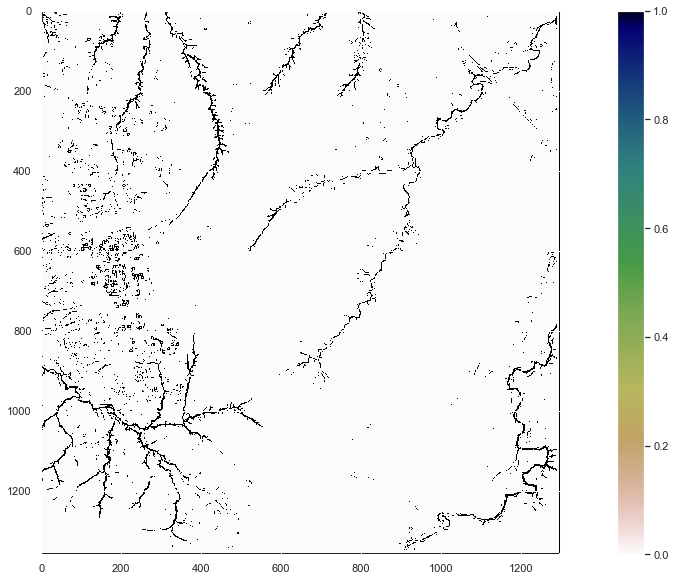

In [29]:
plt.figure(figsize=(20,10));
plt.imshow(curv_dfme_mask, cmap="gist_earth_r");
plt.colorbar();

### Tidy up stray cells

In [30]:
search_window_size = 7

In [31]:
def removeSmallChannels(x):
    """ """
    if x[central_value] == 0:
        keep_gh = 0
    elif np.nansum(x) <= window_size:
        keep_gh = 0
    else:
        keep_gh = 1
    return keep_gh

In [32]:
curvature_layer = np.copy(curv_dfme_mask)
curvature_layer[curvature_layer > 0] = 1

for i in range(1, search_window_size + 1):
    if i == 1:
        input_features = curvature_layer
    else:
        input_features = remove_small_features
    window_size = i*2+1
    central_value = find_median_value(rectangleWindow(window_size, window_size))
    remove_small_features = generic_filter(input_features, 
                                            removeSmallChannels, 
                                           footprint= rectangleWindow(window_size,window_size), 
                                           mode='constant');

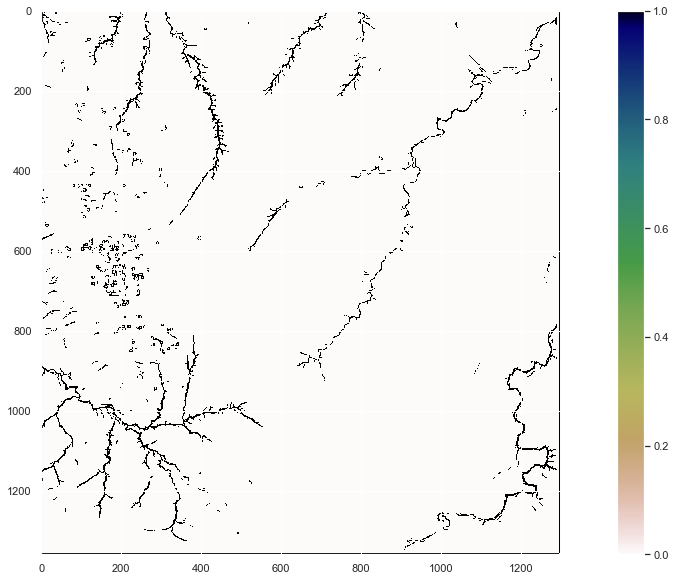

In [33]:
plt.figure(figsize=(20,10));
plt.imshow(remove_small_features, cmap="gist_earth_r");
plt.colorbar();

### Work back down from extended drainage lines until intersecting mapped gully head

In [34]:
def nibbleDrainage(trim_d, ch_id, rsf, tag_val):
    
    """ trim_d == provisional_channel_heads
    ch_id == channel_head_index_positions
    rsf == remove_small_features
    tag_val == value to assign to channel heads"""

    row_size = trim_d.shape[0]
    col_size = trim_d.shape[1]

    # Find the maximum possible drainage line length (assuming they're straight).
    drainage_line_max = np.maximum(trim_d.shape[0], trim_d.shape[1])

    #Upper level loop is for each candidate drainage line.
    for i in range(0, ch_id[0].shape[0]):
        print('candidate: ', i)
        
        # Second level loop is for each grid cell along drainage line
        next_row_index = ch_id[0][i]
        next_col_index = ch_id[1][i]
        if next_row_index == 0 or next_row_index == row_size-1 or next_col_index == 0 or next_col_index == col_size-1:
            pass
        else:
            for j in range(0, drainage_line_max):
                # if the curvature and dfme conditionds are met, end.
                if rsf[next_row_index, next_col_index] == 1:
                    trim_d[next_row_index, next_col_index] = tag_val
                    break
                # If curvature and dfme conditions are not met
                else:
                    #provisional_channel_heads[next_row_index, next_col_index] = 0
                    print(next_row_index, next_col_index)
                    # Find the max value in the immediate 3x3 area
                    immediate_area = trim_d[next_row_index - 1: next_row_index + 2, next_col_index - 1: next_col_index + 2]
                    next_cell = np.max(immediate_area)
                    # find the index position of the max value
                    next_cell_row = np.where(immediate_area==next_cell)[0][0]-1
                    next_cell_col = np.where(immediate_area==next_cell)[1][0]-1
                    next_row_index = next_row_index + next_cell_row
                    next_col_index = next_col_index + next_cell_col
                    if next_row_index == 0 or next_row_index == row_size-1 or next_col_index == 0 or next_col_index == col_size-1:
                        break
                    else:
                        continue
    
    trim_d[trim_d<tag_val] = 0
    trim_d[trim_d==tag_val] = 1
                    
    return trim_d

In [35]:
extended_drainage_index_positions = np.where(extend_drainage == 1)

### Redefine min_drainage (because it gets altered in processes above)

In [36]:
min_drainage = np.copy(catchment_area)
min_drainage[min_drainage < threshold_minimum_drainage] = 0

In [37]:
first_gully_head = nibbleDrainage(min_drainage, extended_drainage_index_positions, remove_small_features, 10000)

candidate:  0
105 1158
105 1159
105 1160
106 1161
105 1162
106 1163
105 1164
105 1165
104 1166
104 1167
104 1168
103 1169
103 1170
103 1171
103 1172
103 1173
102 1174
101 1175
101 1176
102 1177
103 1178
104 1179
104 1180
104 1181
104 1182
105 1183
105 1184
105 1185
105 1186
106 1187
107 1188
107 1189
107 1190
106 1191
106 1192
106 1193
107 1194
107 1195
107 1196
106 1197
106 1198
106 1199
105 1200
105 1201
105 1202
104 1203
104 1204
103 1205
103 1206
103 1207
102 1208
102 1209
102 1210
candidate:  1
186 995
186 996
186 997
187 998
188 998
189 999
190 1000
190 1001
190 1002
191 1003
192 1004
192 1005
193 1006
194 1007
195 1008
196 1009
196 1010
195 1011
195 1012
195 1013
196 1014
196 1015
197 1016
197 1017
197 1018
198 1019
199 1020
200 1021
200 1022
200 1023
200 1024
200 1025
201 1026
202 1027
203 1028
204 1029
205 1030
205 1031
205 1032
204 1033
203 1034
203 1035
203 1036
203 1037
203 1038
202 1039
202 1040
203 1041
203 1042
203 1043
204 1044
204 1045
204 1046
204 1047
204 1048
203 10

552 319
551 319
550 319
549 319
548 319
547 319
546 318
545 318
544 319
543 319
542 318
541 318
540 318
539 318
538 319
candidate:  11
628 156
627 157
627 158
628 159
628 160
candidate:  12
647 304
647 305
646 306
647 307
646 308
646 309
647 310
648 311
649 312
650 313
651 314
652 315
653 316
653 317
654 318
655 319
656 320
657 321
658 322
659 323
660 324
661 325
662 326
663 327
664 328
665 329
666 330
667 330
668 331
669 332
670 333
671 334
672 335
673 335
674 336
675 336
676 337
677 338
678 339
679 340
680 341
681 342
682 343
683 344
683 345
684 346
685 347
686 348
687 349
688 350
689 351
690 352
691 353
692 354
693 355
694 356
695 356
696 357
697 358
698 359
699 360
700 361
701 362
702 363
703 364
704 365
705 366
706 367
707 367
708 367
709 368
710 369
710 370
711 371
712 372
713 373
714 374
715 375
716 376
717 377
717 378
718 379
719 380
720 381
721 382
722 383
723 384
724 385
725 386
726 387
727 388
728 389
729 389
730 389
731 390
732 391
733 392
734 392
735 393
736 393
737 393
73

620 503
619 504
618 505
618 506
617 507
616 508
615 509
614 509
613 510
613 511
612 512
611 513
611 514
610 515
609 516
608 517
607 518
606 518
605 519
604 520
603 521
candidate:  15
689 1092
690 1092
691 1092
692 1093
693 1094
693 1095
693 1096
694 1097
694 1098
695 1099
696 1100
697 1101
697 1102
697 1103
697 1104
697 1105
698 1106
699 1107
699 1108
699 1109
700 1110
700 1111
700 1112
701 1113
701 1114
702 1115
702 1116
702 1117
703 1118
703 1119
704 1120
705 1121
705 1122
705 1123
705 1124
705 1125
704 1126
703 1127
702 1128
701 1128
700 1129
699 1129
698 1130
697 1130
696 1131
695 1132
694 1133
693 1134
692 1135
691 1135
690 1136
689 1137
688 1137
687 1138
686 1139
685 1140
684 1140
683 1141
682 1142
681 1142
680 1143
679 1144
678 1145
677 1144
676 1144
675 1145
674 1146
674 1147
673 1148
672 1148
671 1148
670 1149
669 1150
669 1151
669 1152
669 1153
670 1154
671 1155
671 1156
672 1157
672 1158
673 1159
673 1160
673 1161
673 1162
674 1163
674 1164
675 1165
676 1166
676 1167
677 116

722 728
722 729
722 730
722 731
721 732
720 733
720 734
719 735
719 736
719 737
719 738
719 739
719 740
719 741
719 742
719 743
719 744
719 745
719 746
719 747
719 748
719 749
719 750
719 751
719 752
719 753
719 754
719 755
719 756
718 757
718 758
718 759
718 760
718 761
718 762
718 763
718 764
718 765
718 766
718 767
718 768
718 769
718 770
718 771
719 772
720 772
721 772
722 772
723 773
723 774
723 775
723 776
724 777
724 778
724 779
724 780
725 781
725 782
725 783
726 784
726 785
726 786
726 787
726 788
726 789
726 790
726 791
726 792
727 793
727 794
727 795
728 796
728 797
728 798
728 799
728 800
727 801
726 802
725 802
724 803
723 804
722 804
721 805
721 806
720 807
719 807
718 808
717 808
716 809
715 810
714 810
713 811
712 810
711 810
710 811
709 811
708 812
707 812
706 812
705 813
704 813
703 814
702 814
701 814
700 815
699 815
698 815
697 815
696 815
695 816
694 817
693 818
692 818
691 819
690 819
689 819
688 820
687 821
686 821
685 822
684 823
683 823
682 823
681 824
680 825


482 1293
481 1293
480 1293
479 1293
478 1293
477 1293
476 1293
475 1293
474 1293
473 1293
472 1293
471 1293
470 1293
469 1293
468 1293
467 1293
466 1293
465 1293
464 1293
463 1293
462 1293
461 1293
460 1293
459 1293
458 1293
457 1293
456 1293
455 1293
454 1293
453 1293
452 1293
451 1293
450 1293
449 1293
448 1293
447 1293
446 1293
445 1293
444 1293
443 1293
442 1293
441 1293
440 1293
439 1293
438 1293
437 1293
436 1293
435 1293
434 1293
433 1293
432 1293
431 1293
430 1293
429 1293
428 1293
427 1293
426 1293
425 1293
424 1293
423 1293
422 1293
421 1293
420 1293
419 1293
418 1293
417 1293
416 1293
415 1293
414 1293
413 1293
412 1293
411 1293
410 1293
409 1293
408 1293
407 1293
406 1293
405 1293
404 1293
403 1293
402 1293
401 1293
400 1293
399 1293
398 1293
397 1293
396 1293
395 1293
394 1293
393 1293
392 1293
391 1293
390 1293
389 1293
388 1293
387 1293
386 1293
385 1293
384 1293
383 1293
382 1293
381 1293
380 1293
379 1293
378 1293
377 1293
376 1293
375 1293
374 1293
373 1293
372 1293
3

747 1234
746 1234
745 1235
744 1235
743 1236
742 1236
741 1237
740 1238
739 1239
738 1239
737 1239
736 1239
735 1238
734 1238
733 1239
732 1239
731 1239
730 1240
729 1241
728 1242
727 1243
726 1244
725 1244
724 1245
723 1246
723 1247
723 1248
723 1249
722 1250
721 1249
720 1249
719 1249
718 1250
717 1250
716 1249
715 1249
714 1249
713 1249
712 1249
711 1250
710 1250
709 1251
708 1252
707 1253
706 1254
705 1255
704 1256
703 1257
702 1258
702 1259
701 1260
700 1261
700 1262
700 1263
700 1264
700 1265
700 1266
700 1267
700 1268
699 1269
698 1268
697 1269
696 1269
695 1270
694 1271
693 1271
692 1271
691 1272
690 1272
689 1273
688 1273
687 1274
686 1274
685 1274
684 1275
683 1276
683 1277
682 1278
681 1279
680 1280
679 1281
678 1282
677 1283
676 1283
675 1283
674 1283
673 1282
672 1281
671 1280
670 1279
669 1278
668 1277
668 1276
668 1275
667 1274
666 1273
665 1273
664 1273
663 1273
662 1273
661 1272
660 1272
659 1272
658 1272
657 1272
656 1272
655 1272
654 1273
653 1273
652 1273
651 1273
6

1050 961
1049 962
1048 963
1048 964
1048 965
1048 966
1048 967
1049 968
1050 969
1051 970
1051 971
1051 972
1050 973
1049 974
1048 975
1047 976
1046 977
1045 978
1044 979
1044 980
1044 981
1044 982
1045 983
1045 984
1045 985
1046 986
1047 987
1048 988
1048 989
1048 990
1048 991
1048 992
1048 993
1049 994
1050 995
1051 996
1051 997
1051 998
1051 999
1051 1000
1051 1001
1051 1002
1051 1003
1052 1004
1052 1005
1053 1006
1054 1007
1055 1008
1055 1009
1055 1010
1055 1011
1055 1012
1055 1013
1055 1014
1055 1015
1056 1016
1057 1017
1057 1018
1057 1019
1057 1020
1057 1021
1057 1022
1057 1023
1057 1024
1057 1025
1057 1026
1056 1027
1056 1028
1055 1029
1055 1030
1054 1031
1054 1032
1054 1033
1055 1034
1055 1035
1055 1036
1055 1037
1055 1038
1055 1039
1055 1040
1055 1041
1056 1042
1056 1043
1056 1044
1056 1045
1056 1046
1057 1047
1057 1048
1057 1049
1057 1050
1057 1051
1058 1052
1058 1053
1058 1054
1058 1055
1058 1056
1058 1057
1058 1058
1058 1059
1058 1060
1058 1061
1058 1062
1059 1063
1060 1064

1177 502
1176 502
1175 502
1174 501
1173 500
1172 500
1171 500
1170 500
1169 500
1168 500
1167 499
1166 499
1165 499
1164 499
1163 499
1162 498
1161 498
1160 498
1159 497
1158 496
1157 496
1156 496
1155 495
1154 495
1153 495
1152 494
1151 493
1150 493
1149 492
1148 491
1147 490
1146 490
1145 489
1144 488
1143 488
1142 487
1141 486
1140 485
1139 485
1138 485
1137 484
1136 483
1135 482
1134 481
1134 480
1133 479
1132 478
1131 477
1131 476
1130 475
1129 474
1128 473
1127 472
1126 471
1125 471
1124 471
1123 470
1122 469
1122 468
1122 467
1121 466
1120 465
1120 464
1119 463
1118 462
1117 461
1116 461
1115 461
1114 461
1113 460
1112 459
1111 458
1110 457
1109 456
1109 455
1108 454
1107 453
1107 452
1106 451
1105 450
1104 449
1103 448
1102 448
1101 447
1100 446
1099 445
1098 444
1097 443
1097 442
1096 441
1095 441
1094 440
1093 440
1092 440
1091 440
1090 440
1089 440
1088 440
1087 440
1086 440
1085 440
1084 440
1083 440
1082 440
1081 439
1080 439
1079 439
1078 438
1077 437
1076 436
1075 435
1

1355 470
1355 471
1355 472
1355 473
1355 474
1355 475
1355 476
1355 477
1355 478
1355 479
1355 480
1355 481
1355 482
1355 483
1355 484
1355 485
1355 486
1355 487
1355 488
1355 489
1355 490
1355 491
1355 492
1355 493
1355 494
1355 495
1355 496
1355 497
1355 498
1355 499
1355 500
1355 501
1355 502
1355 503
1355 504
1355 505
1355 506
1355 507
1355 508
1355 509
1355 510
1355 511
1355 512
1355 513
1355 514
1355 515
1355 516
1355 517
1355 518
1355 519
1355 520
1355 521
1355 522
1355 523
1355 524
1355 525
1355 526
1355 527
1355 528
1355 529
1355 530
1355 531
1355 532
1355 533
1355 534
1355 535
1355 536
1355 537
1355 538
1355 539
1355 540
1355 541
1355 542
1355 543
1355 544
1355 545
1355 546
1355 547
1355 548
1355 549
1355 550
1355 551
1355 552
1355 553
1355 554
1355 555
1355 556
1355 557
1355 558
1355 559
1355 560
1355 561
1355 562
1355 563
1355 564
1355 565
1355 566
1355 567
1355 568
1355 569
1355 570
1355 571
1355 572
1355 573
1355 574
1355 575
1355 576
1355 577
1355 578
1355 579
1355 580
1

# Count first estimate of number of gully heads

In [38]:
np.sum(first_gully_head)

34.0

## Mask by catchment boundary

In [39]:
masked_gully_heads = first_gully_head * dem_mask

## Look at number of remaining gully heads

In [40]:
np.sum(masked_gully_heads)

14.0

## Isolate all gully head nodes

In [41]:
find_nodes = np.multiply(masked_gully_heads, grid_nodes);

## Create array of only gully head nodes 

In [42]:
gh_array = np.unique(find_nodes).astype('int32');

## Turn gully head node array into a list and remove the value 0

In [43]:
gh_list = gh_array.tolist();
gh_list.remove(0);

# Run multiple-direction flow routing algorithm

In [44]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
#flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
fa.run_one_step();
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step();

da = np.array(mg.at_node['drainage_area'].round(4))
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
frn = mg.at_node['flow__receiver_node']
drainage_area = np.flip(da.reshape(mg.shape), 0);
frp = np.array(mg.at_node['flow__receiver_proportions']);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);

catchment_area = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

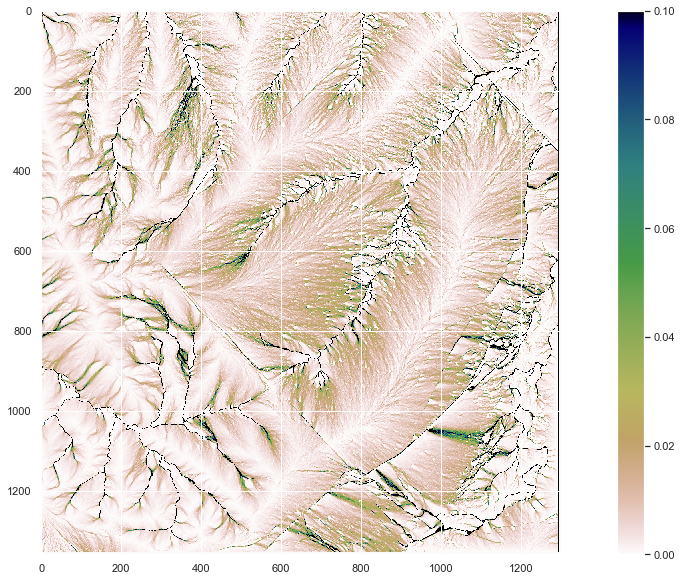

In [45]:
plt.figure(figsize=(20,10));
plt.imshow(catchment_area, cmap="gist_earth_r", vmax = .1);
plt.colorbar();

### The final variable in the function below sets the threshold catchment area at the point of convergence required to keep the gully head as a candidate. Default set to 0.1 ha.

## Work through list finding index positions of each node. catchment_area_node_list is the list of nodes where flow converges to a single cell.

In [46]:
catchment_area_dict, catchment_area_node_list = findGullyHeadNode(gh_list, grid_nodes, input_DEM, catchment_area,
                                                                  input_DEM_resolution, 10, convergence_threshold, 
                                                                  threshold_minimum_drainage);

max ca:  0.34766008
Node id:  220 Catchment area:  0.0954118
Node id:  199 Catchment area:  0.11841475
Node id:  178 Catchment area:  0.20857992
max ca:  0.46820454
Node id:  220 Catchment area:  0.0392113
Node id:  199 Catchment area:  0.03046339
Node id:  179 Catchment area:  0.08023272
Node id:  158 Catchment area:  0.14836429
max ca:  11.22790388
Node id:  220 Catchment area:  7.01207489
Node id:  199 Catchment area:  5.36415334
max ca:  0.29326085
Node id:  220 Catchment area:  0.17218806
Node id:  221 Catchment area:  0.23433709
max ca:  0.87583759
Node id:  220 Catchment area:  0.36381192
max ca:  1.53777163
Node id:  220 Catchment area:  0.48278683
Node id:  199 Catchment area:  0.66744287
max ca:  0.22238648
Node id:  220 Catchment area:  0.06772028
Node id:  221 Catchment area:  0.07846412
Node id:  243 Catchment area:  0.08777052
Node id:  265 Catchment area:  0.1245663
Node id:  287 Catchment area:  0.12421709
Node id:  288 Catchment area:  0.14196335
Node id:  289 Catchmen

# Create a list of all gully head nodes that had a valid convergence point.

### In the catchment_area_dict the key is the initial gully head node and the value is the node where flow converges to a single cell (cp).

## This is a list of all initial gully heads to keep. Can have duplicates because some gully heads share a convergence point.

In [47]:
gully_heads_to_keep = get_keys(catchment_area_node_list, catchment_area_dict);
initial_gully_heads = np.isin(grid_nodes,gully_heads_to_keep).astype('int64');
initial_gully_head_and_cp_df = pd.DataFrame.from_dict(catchment_area_dict, orient='index');
initial_head_column = np.array(initial_gully_head_and_cp_df.index);
initial_gully_head_and_cp_df['initial'] = initial_head_column;
initial_gully_head_and_cp_df.rename(columns={0: 'cp'}, inplace=True);

## This is a grid of all convergence points.

In [48]:
initial_cp_nodes = np.isin(grid_nodes,catchment_area_node_list).astype('int64');

In [49]:
initial_gh_nodes = np.isin(grid_nodes,initial_gully_head_and_cp_df['initial'].values).astype('int64');

In [50]:
np.sum(initial_cp_nodes)

12

# Can collect catchment area at this stage but need a reliable estimate of it (from a drainage area grid run with overlapping tiles).

In [51]:
cp_da_dict = {}

for i in catchment_area_node_list:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    cp_da = catchment_area[row_index,col_index];
    cp_da_dict[i] = np.round(cp_da, 5);
    
cp_da_df = pd.DataFrame.from_dict(cp_da_dict, orient='index');
cp_da_df['cp'] = cp_da_df.index
initial_head_cp_df = initial_gully_head_and_cp_df.merge(cp_da_df, on="cp", how = 'inner');
initial_head_cp_df.rename(columns={0: 'area'}, inplace=True);


In [52]:
initial_gh_da = initial_head_cp_df['initial'].values.tolist()

In [53]:
igh_da_dict = {}

for i in initial_gh_da:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    igh_da = catchment_area[row_index,col_index];
    igh_da_dict[i] = np.round(igh_da, 5);
    
igh_da_df = pd.DataFrame.from_dict(igh_da_dict, orient='index')
igh_da_df['initial'] = igh_da_df.index
initial_head_cp_ighda_df = initial_head_cp_df.merge(igh_da_df, on="initial", how = 'inner')
initial_head_cp_ighda_df.rename(columns={0: 'gh_area'}, inplace=True)


In [54]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Now move 5m downstream of the remaining gully heads - this moves 5m downstream of 'gully_heads_to_keep' which is the list of inital gully heads meeting the convergence criterion.

In [55]:
downstream_5m_dict, downstream_5m_node_list = findPoint5mDownstream(gully_heads_to_keep, grid_nodes, input_DEM, catchment_area,
                                                                  input_DEM_resolution, 6) 

downstream_5m_df = pd.DataFrame.from_dict(downstream_5m_dict, orient='index')
downstream_5m_df['initial'] = downstream_5m_df.index
downstream_5m_df.rename(columns={0: '5m'}, inplace=True)

#initial_head_cp_5m_df = filter_test.merge(downstream_5m_df, on="initial", how = 'inner')
initial_head_cp_5m_df = initial_head_cp_ighda_df.merge(downstream_5m_df, on="initial", how = 'inner')

downstream_5m_node_array = np.isin(grid_nodes,downstream_5m_node_list).astype('int64')

max ca:  0.30884269
Node id:  84 Catchment area:  0.0954118
Node id:  71 Catchment area:  0.11841475
Node id:  58 Catchment area:  0.20857992
Node id:  46 Catchment area:  0.27176041
Node id:  34 Catchment area:  0.26629331
Node id:  21 Catchment area:  0.21520815
5
max ca:  0.32766222
Node id:  84 Catchment area:  0.0392113
Node id:  71 Catchment area:  0.03046339
Node id:  59 Catchment area:  0.08023272
Node id:  46 Catchment area:  0.14836429
Node id:  33 Catchment area:  0.18726089
Node id:  20 Catchment area:  0.16011293
5
max ca:  11.22214705
Node id:  84 Catchment area:  7.01207489
Node id:  71 Catchment area:  5.36415334
Node id:  72 Catchment area:  9.98924555
Node id:  60 Catchment area:  10.70605597
Node id:  48 Catchment area:  6.27283371
Node id:  49 Catchment area:  11.21357588
5
max ca:  0.29326085
Node id:  84 Catchment area:  0.17218806
Node id:  85 Catchment area:  0.23433709
Node id:  86 Catchment area:  0.29326085
Node id:  87 Catchment area:  0.26375102
Node id:  8

In [56]:
np.sum(downstream_5m_node_array)

12

### Remove any gully heads around edges of the DEM

In [57]:
# Must be larger than 'line_length' (specified later).
size_of_edge = 30

In [58]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))
find_nodes = np.multiply(downstream_5m_node_array, grid_nodes);

gully_head_edge_mask = np.zeros([grid_nodes.shape[0], grid_nodes.shape[1]])
gully_head_mask_centre = np.ones([grid_nodes.shape[0] - size_of_edge*2, grid_nodes.shape[1] - size_of_edge*2])
gully_head_edge_mask[size_of_edge:-1*(size_of_edge), size_of_edge:-1*(size_of_edge)] = gully_head_mask_centre

remaining_gully_heads = find_nodes * gully_head_edge_mask
gh_array = np.unique(remaining_gully_heads).astype(int);
gh_list = gh_array.tolist();
gh_list.remove(0);
len(gh_list)

12

## Calculate slope

In [59]:
slope = generic_filter(input_DEM, slopeWindowMperM,
                  footprint= rectangleWindow(3,3),
                  mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

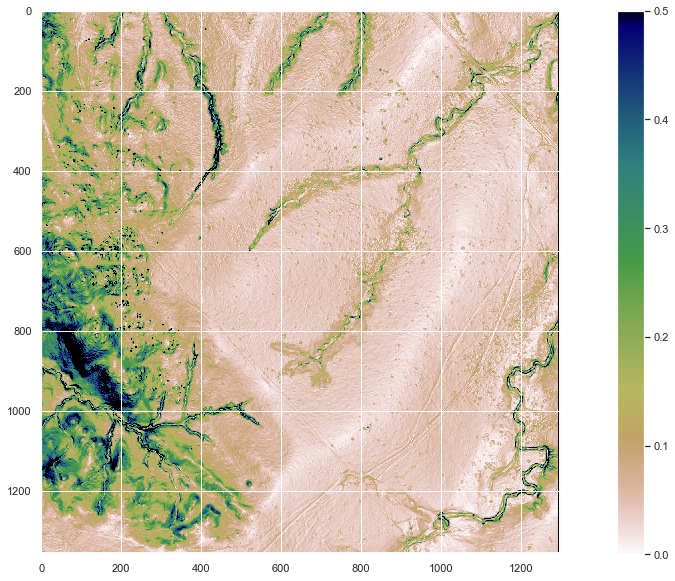

In [60]:
plt.figure(figsize=(20,10));
plt.imshow(slope, cmap="gist_earth_r", vmax = 0.5);
plt.colorbar();

## Specific the size of the area to be checked. This represents a physical distance from the outlet but has no unit of measure.

In [61]:
distance_from_outlet = 20

## Move upstream from the point 5m downstream until the gully head position is found. The first input is the maximum upstream distance checked.

In [62]:
len(gh_list)

12

In [63]:
final_gh_and_5m_downstream, gullies_to_keep_dict, gh_stdev = upstreamDrainageLine(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,gh_list, step_s, comp_d, dfme_threshold, 
                                                                        gh_min_elev)

840
(41, 41)
881
921
961
1002
1043
1085
1126
1168
1209
1250
1292
1332
1374
1415
1457
1499
1540
1580
1621
1620
[167.09782409667969, 167.25596618652344, 167.39344787597656, 167.61231994628906, 167.81401062011719, 168.06294250488281, 168.17869567871094, 168.33650207519531, 168.39714050292969, 168.52967834472656, 168.5509033203125, 168.59869384765625, 168.66748046875, 168.71438598632813, 168.74705505371094, 168.82258605957031, 168.85066223144531, 168.9581298828125, 169.02020263671875, 169.0234375]
node:  267065
minimum downstream value:  -0.266154779674
mean upstream value:  -0.00869415545281
std upstream value:  0.0122953925547
840
(41, 41)
881
922
963
1004
1045
1085
1125
1165
1164
1163
1162
1202
1242
1282
1322
1362
1361
1401
1441
1482
[164.78631591796875, 164.91464233398438, 165.07400512695313, 165.23074340820313, 165.40975952148438, 165.65118408203125, 165.87890625, 166.0706787109375, 166.14994812011719, 166.20620727539063, 166.274658203125, 166.379638671875, 166.45841979980469, 166.563

840
(41, 41)
799
758
717
677
636
595
554
514
473
432
391
350
309
268
226
186
145
103
62
63
[179.20069885253906, 179.24493408203125, 179.25831604003906, 179.40118408203125, 179.47201538085938, 179.51480102539063, 179.63215637207031, 179.77235412597656, 179.88835144042969, 179.98736572265625, 180.09205627441406, 180.20356750488281, 180.30558776855469, 180.40083312988281, 180.56109619140625, 180.62471008300781, 180.67085266113281, 180.73785400390625, 180.82484436035156, 180.87345886230469]
node:  1062481
minimum downstream value:  -0.227657154149
mean upstream value:  -0.170845184785
std upstream value:  0.0213857950024
840
(41, 41)
839
838
837
796
754
794
793
751
750
708
707
665
664
663
662
661
660
659
658
657
[173.07435607910156, 173.11920166015625, 172.99856567382813, 173.21044921875, 173.31513977050781, 173.44783020019531, 173.53761291503906, 173.62294006347656, 173.66850280761719, 173.73130798339844, 173.76365661621094, 173.78631591796875, 173.8375244140625, 173.86155700683594, 173.9

In [64]:
gully_head_std_df = pd.DataFrame(gh_stdev)

In [65]:
gully_head_std_df.to_excel("ps_6_test.xlsx")  

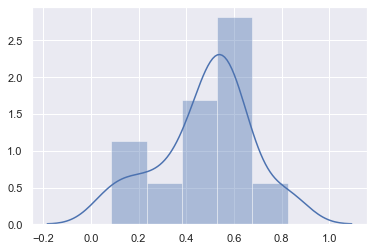

In [66]:
sns.distplot(gully_head_std_df)

### In the final gully head dictionary the key is the point 5 m downstream of the gully head (later CP) and the value is the gully head found by moving back upstream (later GH)

In [67]:
final_and_5m_df = pd.DataFrame.from_dict(final_gh_and_5m_downstream, orient='index')
final_and_5m_df['5m'] = final_and_5m_df.index
initial_cp_5m_final_df = initial_head_cp_5m_df.merge(final_and_5m_df, on="5m", how = 'inner')
initial_cp_5m_final_df.rename(columns={0: 'final'}, inplace=True)

In [68]:
len(initial_cp_5m_final_df)

7

In [69]:
final_5m_downstream, final_gully_heads = get_values(final_gh_and_5m_downstream)

In [70]:
slope_above_head, elevation_above_head = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 5);

slope_above_head_df = pd.DataFrame.from_dict(slope_above_head, orient='index');
slope_above_head_df.rename(columns={0: 'GHSlope', 1: 'final'}, inplace=True);

elevation_above_head_df = pd.DataFrame.from_dict(elevation_above_head, orient='index');
elevation_above_head_df.rename(columns={0: 'GHelevation', 1: 'final'}, inplace=True);

840
(41, 41)
882
923
965
1006
1047
1089
5   5
1129
1171
1212
1254
1296
1337
1377
1418
1459
1500
1541
1582
1623
1624
840
(41, 41)
880
920
960
959
958
957
5   5
997
1037
1077
1117
1157
1156
1196
1236
1277
1317
1357
1398
1439
1480
840
(41, 41)
881
921
962
1002
1042
1083
5   5
1124
1165
1206
1247
1287
1327
1326
1366
1365
1405
1445
1485
1484
1483
840
(41, 41)
799
758
718
677
636
595
5   5
554
513
472
430
390
349
307
266
225
183
142
101
59
58
840
(41, 41)
880
879
837
836
794
793
5   5
751
750
749
748
747
746
745
744
743
742
741
740
739
698
840
(41, 41)
798
797
837
877
876
916
5   5
915
955
954
994
1034
1074
1115
1155
1195
1235
1275
1274
1273
1272
840
(41, 41)
880
921
962
1003
1044
1085
5   5
1127
1168
1209
1250
1291
1332
1373
1414
1455
1496
1536
1577
1619
1620


In [71]:
initial_cp_5m_final_df

,cp,initial,area,gh_area,5m,final
0,270963,273563,0.20858,0.09541,267065,273563
1,275050,278949,0.14836,0.03921,272450,278950
2,781822,783122,0.66744,0.48279,776623,783122
3,1057282,1055982,0.50651,0.83443,1062481,1055982
4,1116052,1114748,1.60481,0.98579,1116053,1113449
5,1151148,1149845,1.45789,1.21461,1151150,1149845
6,1204509,1205808,0.34509,0.27208,1199309,1205808


In [72]:
slope_and_elevation_5m_df = slope_above_head_df.merge(elevation_above_head_df, on="final", how = 'inner')

In [73]:
slope_above_head_10m, elevation_above_head_10m = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 10);

slope_above_head_10m_df = pd.DataFrame.from_dict(slope_above_head_10m, orient='index');
slope_above_head_10m_df.rename(columns={0: 'GHSlope10', 1: 'final'}, inplace=True);

elevation_above_head_10m_df = pd.DataFrame.from_dict(elevation_above_head_10m, orient='index');
elevation_above_head_10m_df.rename(columns={0: 'GHelevation10', 1: 'final'}, inplace=True);

840
(41, 41)
882
923
965
1006
1047
1089
1129
1171
1212
1254
1296
10   10
1337
1377
1418
1459
1500
1541
1582
1623
1624
840
(41, 41)
880
920
960
959
958
957
997
1037
1077
1117
1157
10   10
1156
1196
1236
1277
1317
1357
1398
1439
1480
840
(41, 41)
881
921
962
1002
1042
1083
1124
1165
1206
1247
1287
10   10
1327
1326
1366
1365
1405
1445
1485
1484
1483
840
(41, 41)
799
758
718
677
636
595
554
513
472
430
390
10   10
349
307
266
225
183
142
101
59
58
840
(41, 41)
880
879
837
836
794
793
751
750
749
748
747
10   10
746
745
744
743
742
741
740
739
698
840
(41, 41)
798
797
837
877
876
916
915
955
954
994
1034
10   10
1074
1115
1155
1195
1235
1275
1274
1273
1272
840
(41, 41)
880
921
962
1003
1044
1085
1127
1168
1209
1250
1291
10   10
1332
1373
1414
1455
1496
1536
1577
1619
1620


In [74]:
slope_and_elevation_10m_df1 = slope_and_elevation_5m_df.merge(slope_above_head_10m_df, on="final", how = 'inner')

In [75]:
slope_and_elevation_10m_df = slope_and_elevation_10m_df1.merge(elevation_above_head_10m_df, on="final", how = 'inner')

In [76]:
def drainageSlope(e1,e2):
    return max((e2-e1)/5, 0.0001)

slope_and_elevation_10m_df['drainage_slope'] = slope_and_elevation_10m_df.apply(lambda x: drainageSlope(x['GHelevation'], x['GHelevation10']), axis=1)
 

No handles with labels found to put in legend.


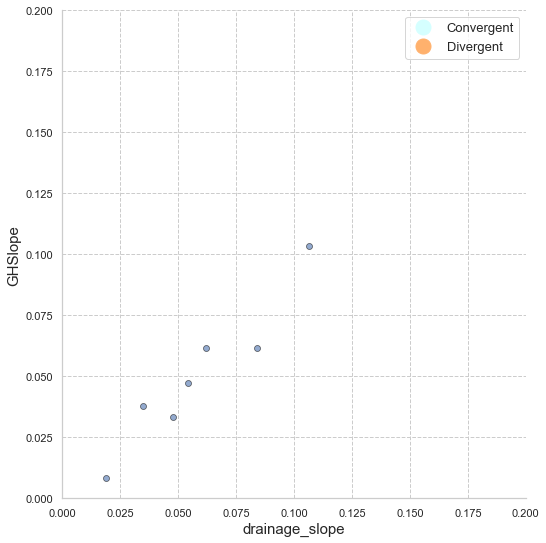

In [77]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = slope_and_elevation_10m_df
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'drainage_slope'
y_axis = 'GHSlope'

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.0,0.2)
ax.set_ylim(0.0,0.2)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis, fontsize = 15)
ax.set_ylabel((y_axis), fontsize = 15)

#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(8,8)

In [78]:
final_gully_head_nodes = np.isin(grid_nodes,final_gully_heads).astype('int64')

In [79]:
len(final_gully_heads)

7

# Locate gully edges.

# Check whether gully edges meet same criteria as gully head earlier (can be modified), then locate edges next to 5m_downstream_points and gh.

In [ ]:
#option to hack gully edge function to always accept (also need to change outcome conditions below)
def checkGullyEdgesElev(dfme_list, elev_list,step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change,std_threshold):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_upstream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_upstream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        #std_upstream = np.std(upstream_nodes)
        std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])
        elevation_difference = np.median(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])-np.median(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('elevation difference: ', elevation_difference)
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < std_threshold and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 5

    return keep_gully, gully_head_location

In [80]:
start_time = timeit.default_timer()

line_length = 20
list_of_final_gully_heads = []
gully_edges_dict = {}
for key, value in final_gh_and_5m_downstream.items():
    cp = key
    print('cp: ',cp)
    gh = value
    print('gh: ', gh)
    gh_lat = np.where(grid_nodes == gh)[0][0]
    cp_lat = np.where(grid_nodes == cp)[0][0]
    gh_lon = np.where(grid_nodes == gh)[1][0]
    cp_lon = np.where(grid_nodes == cp)[1][0]

    lat_displacement = cp_lat - gh_lat
    print('lat: ', lat_displacement)
    lon_displacement = gh_lon - cp_lon
    print('lon: ', lon_displacement)

    # a^2 + b^2 = c^2
    gully_length = np.sqrt(lat_displacement**2 + lon_displacement**2)
    
    gully_angle = gullyUnknownAngle(lat_displacement, lon_displacement)   
    
    gully_and_cross_section = GullyOrientation(gully_angle, key, mg.shape)
    
    approx_angle = gully_and_cross_section.closest_angle
        
    cross_section_nodes = gully_and_cross_section.cross_section(line_length)
    
    result = np.where(grid_nodes == key)
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    #################################################################################################
    # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
    # central grid node of the subset.
    subset_row_top = int(row_index - line_length)
    subset_row_bot = int(row_index + line_length) + 1
    subset_col_left = int(col_index - line_length)
    subset_col_right = int(col_index + line_length) + 1
    #################################################################################################
    # Restrict the size of the subset in cases where it is on the edge of a DEM.
    subset_row_top_adjusted = max(subset_row_top, 0);
    subset_row_bot_adjusted = min(subset_row_bot, input_DEM.shape[0]);
    subset_col_left_adjusted = max(subset_col_left, 0);
    subset_col_right_adjusted = min(subset_col_right, input_DEM.shape[1]);
    #################################################################################################
    # Find the offset required by restricting the size of the subset around DEM edges.
    # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
    offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
    offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
    offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
    offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
    #################################################################################################
    # Create subset around the current gully head grid node. 
    grid_nodes_subset_copy = np.copy(grid_nodes).astype('int32');
    grid_nodes_subset = grid_nodes_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    lat = grid_nodes_subset.shape[0]
    lon = grid_nodes_subset.shape[1]

    nodes_1d = np.squeeze(grid_nodes_subset.reshape(1, lat * lon))

    cross_section_subset_mask = np.isin(nodes_1d,cross_section_nodes).reshape(grid_nodes_subset.shape)
    cross_section_subset_image = cross_section_subset_mask.astype('int64')

    #################################################################################################
    # Take subsets of desired surface parameters for gulyl analysis (e.g. DFME, slope, curvature etc)
    #################################################################################################
    elevation_subset_copy = np.copy(input_DEM).astype('float32');
    cross_section_elevation = elevation_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_elevation[~cross_section_subset_mask] = np.nan
    cross_section_elevation_1d = np.squeeze(cross_section_elevation.reshape(1, lat * lon))
    #################################################################################################
    dfme_subset_copy = np.copy(DFME).astype('float32');
    cross_section_dfme = dfme_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_dfme[~cross_section_subset_mask] = np.nan
    cross_section_dfme_1d = np.squeeze(cross_section_dfme.reshape(1, lat * lon))
    #################################################################################################
    
    node_cross_section_dfme_dict = {}
    for A, B in zip(nodes_1d, cross_section_dfme_1d):
        node_cross_section_dfme_dict[A] = B
    
    node_cross_section_elevation_dict = {}
    for A, B in zip(nodes_1d, cross_section_elevation_1d):
        node_cross_section_elevation_dict[A] = B
        
    dfme_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_dfme_dict.items() if ~np.isnan(value) }

    elevation_cross_section_unordered = { key:value for key, 
                                         value in node_cross_section_elevation_dict.items() if ~np.isnan(value) }

    ds = [dfme_cross_section_unordered, elevation_cross_section_unordered]
    d = {}
    for k in dfme_cross_section_unordered.keys():
        d[k] = tuple(d[k] for d in ds)

    cross_section_parameters = pd.DataFrame.from_dict(d)

    cross_section_parameters.rename(index={0:'DFME', 1:'Elevation'}, inplace=True)

    cross_section_parameters_transpose = cross_section_parameters.T

    cross_section_parameters_transpose.insert(0, "Distance", 0)
    
    for j in range(0, (line_length * 2)+1):
        if j < line_length:
            cross_section_parameters_transpose.iloc[j,0] = -line_length + j
        else:
            cross_section_parameters_transpose.iloc[j,0] = j - line_length
        
    cross_section_parameters_transpose['Node'] = cross_section_parameters_transpose.index.values
    
    dir1, dir1_nodes, dir2, dir2_nodes = assignDirection(cross_section_parameters_transpose, 
                                                 gully_and_cross_section.closest_angle)
    
    dir1e, dir1_nodes, dir2e, dir2_nodes = assignDirectionElev(cross_section_parameters_transpose, 
                                             gully_and_cross_section.closest_angle)
    
    
    outcome_d1, D1 = checkGullyEdgesElev(dir1,dir1e, step_s,comp_d,dfme_threshold,gh_min_elev, gh_relief, 1);
    outcome_d2, D2 = checkGullyEdgesElev(dir2, dir2e, step_s,comp_d,dfme_threshold,gh_min_elev, gh_relief,1);
    print('D1 val: ', D1)
    print('D2 val: ', D2)
    
    #if outcome_d1 == 'yes' or outcome_d1 == 'no' and outcome_d2 == 'yes' or outcome_d2 == 'no':
    if outcome_d1 == 'yes' and outcome_d2 == 'yes':

        list_of_final_gully_heads.append(key)
        # Directions will depend on orientation so need two sets of schemes.
        if approx_angle == 180 or approx_angle == 225 or approx_angle == 270 or approx_angle == 315:
            
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir1_nodes[D1], dir2_nodes[D2], points_next_to_head_d1, points_next_to_head_d2]
            
        else:
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir2_nodes[D2],dir1_nodes[D1], points_next_to_head_d2, points_next_to_head_d1]
        
    else:
        print('no')

    
timeit.default_timer() - start_time

cp:  267065
gh:  273563
lat:  -5
lon:  -2
Quadrant = Q3 min angle 180 max angle 270
north-south gully
elevation difference:  0.836135864258
elevation difference:  0.597900390625
D1 val:  5
D2 val:  5
south_to_north gully
south_to_north gully
d1 :  267060 d2:  267070 New points:  273560 273570 angle:  180
cp:  272450
gh:  278950
lat:  -5
lon:  0
north-south gully
elevation difference:  0.498550415039
elevation difference:  0.846969604492
D1 val:  5
D2 val:  5
south_to_north gully
south_to_north gully
d1 :  272445 d2:  272455 New points:  278945 278955 angle:  180
cp:  776623
gh:  783122
lat:  -5
lon:  -1
Quadrant = Q3 min angle 180 max angle 270
north-south gully
elevation difference:  0.425964355469
elevation difference:  0.784317016602
D1 val:  5
D2 val:  5
south_to_north gully
south_to_north gully
d1 :  776618 d2:  776628 New points:  783118 783128 angle:  180
cp:  1062481
gh:  1055982
lat:  5
lon:  1
Quadrant = Q1 min angle 0 max angle 90
north-south gully
elevation difference:  0.5

0.905022300008568

# Check the list of final gully heads.

In [81]:
final_5m_downstream_nodes = np.isin(grid_nodes,list_of_final_gully_heads).astype('int64')
len(list_of_final_gully_heads)

7

In [82]:
gully_edges_df = pd.DataFrame.from_dict(gully_edges_dict).T
gully_edges_df.columns = ['LeftCP', 'RightCP', 'LeftGH', 'RightGH']
gully_edges_df['5m'] = gully_edges_df.index
initial_cp_5m_final_edges_df = initial_cp_5m_final_df.merge(gully_edges_df, on="5m", how = 'inner')

## Compare drainage area of final gh to cp and initial gh and throw out any with large differences.

In [83]:
final_gh_da = initial_cp_5m_final_edges_df['final'].values.tolist() 

In [84]:
fgh_da_dict = {}

for i in final_gh_da:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    fgh_da = catchment_area[row_index,col_index];
    fgh_da_dict[i] = np.round(fgh_da, 5);
    
fgh_da_df = pd.DataFrame.from_dict(fgh_da_dict, orient='index')
fgh_da_df['final'] = fgh_da_df.index
initial_cp_5m_final_da_df = initial_cp_5m_final_edges_df.merge(fgh_da_df, on="final", how = 'inner')
initial_cp_5m_final_da_df.rename(columns={0: 'fgh_area'}, inplace=True)


In [85]:
final_gh_copy = initial_cp_5m_final_da_df.copy()

## Combine points around head with GH slope estimate.

In [86]:
gully_topographic_data = final_gh_copy.merge(slope_and_elevation_10m_df, on="final", how = 'inner')

In [87]:
gully_topographic_data['GHSlopeMean'] = gully_topographic_data[['GHSlope', 'GHSlope10']].mean(axis=1)

## Extract each point seperately.

In [88]:
left_edge_points = gully_edges_df['LeftCP'].values
right_edge_points = gully_edges_df['RightCP'].values
left_head_points = gully_edges_df['LeftGH'].values
right_head_points = gully_edges_df['RightGH'].values
gully_left_edges = np.isin(grid_nodes,left_edge_points).astype('int64')
gully_right_edges = np.isin(grid_nodes,right_edge_points).astype('int64')
gully_left_head = np.isin(grid_nodes,left_head_points).astype('int64')
gully_right_head = np.isin(grid_nodes,right_head_points).astype('int64')

left_cp_slope = getSlopeValues(left_edge_points, slope, grid_nodes)
right_cp_slope = getSlopeValues(right_edge_points, slope, grid_nodes)
left_head_slope = getSlopeValues(left_head_points, slope, grid_nodes)
right_head_slope = getSlopeValues(right_head_points, slope, grid_nodes)

left_cp_slope_df = pd.DataFrame.from_dict(left_cp_slope, orient='index')
left_cp_slope_df['LeftCP'] = left_cp_slope_df.index
all_data_plus_left_cp = gully_topographic_data.merge(left_cp_slope_df, on="LeftCP", how = 'inner')
all_data_plus_left_cp.rename(columns={0: 'LeftCPslope'}, inplace=True)

right_cp_slope_df = pd.DataFrame.from_dict(right_cp_slope, orient='index')
right_cp_slope_df['RightCP'] = right_cp_slope_df.index
all_data_plus_right_cp = all_data_plus_left_cp.merge(right_cp_slope_df, on="RightCP", how = 'inner')
all_data_plus_right_cp.rename(columns={0: 'RightCPslope'}, inplace=True)

left_head_slope_df = pd.DataFrame.from_dict(left_head_slope, orient='index')
left_head_slope_df['LeftGH'] = left_head_slope_df.index
all_data_plus_left_gh = all_data_plus_right_cp.merge(left_head_slope_df, on="LeftGH", how = 'inner')
all_data_plus_left_gh.rename(columns={0: 'LeftGHslope'}, inplace=True)

right_head_slope_df = pd.DataFrame.from_dict(right_head_slope, orient='index')
right_head_slope_df['RightGH'] = right_head_slope_df.index
all_data_plus_right_gh = all_data_plus_left_gh.merge(right_head_slope_df, on="RightGH", how = 'inner')
all_data_plus_right_gh.rename(columns={0: 'RightGHslope'}, inplace=True)

all_data_plus_right_gh['median'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].median(axis=1)
all_data_plus_right_gh['std'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].std(axis=1)



In [89]:
all_data_plus_right_gh.head()

,cp,initial,area,gh_area,5m,final,LeftCP,RightCP,LeftGH,RightGH,fgh_area,GHSlope,GHelevation,GHSlope10,GHelevation10,drainage_slope,GHSlopeMean,LeftCPslope,RightCPslope,LeftGHslope,RightGHslope,median,std
0,270963,273563,0.20858,0.09541,267065,273563,267060,267070,273560,273570,0.09541,0.047300,168.550903,0.031017,168.822586,0.054337,0.039159,0.209,0.215,0.181,0.109,0.181000,0.072232
1,275050,278949,0.14836,0.03921,272450,278950,272445,272455,278945,278955,0.03770,0.061600,166.274658,0.050842,166.693726,0.083813,0.056221,0.182,0.180,0.116,0.076,0.116000,0.056475
2,781822,783122,0.66744,0.48279,776623,783122,776618,776628,783118,783128,0.48279,0.033242,178.773926,0.041071,179.011826,0.047580,0.037157,0.159,0.084,0.028,0.033,0.033242,0.056055
3,1057282,1055982,0.50651,0.83443,1062481,1055982,1062486,1062476,1055986,1055976,0.83443,0.103462,180.092056,0.059713,180.624710,0.106531,0.081587,0.106,0.077,0.103,0.099,0.103000,0.011836
4,1116052,1114748,1.60481,0.98579,1116053,1113449,1109558,1122548,1103057,1116047,1.05250,0.037824,173.763657,0.032960,173.938202,0.034909,0.035392,0.088,0.069,0.059,0.181,0.069000,0.055595


In [90]:
gully_head_node_array = np.isin(grid_nodes,all_data_plus_right_gh['final'].values).astype('int64')

In [91]:
np.sum(gully_head_node_array)

7

In [92]:
df_filtered = all_data_plus_right_gh[all_data_plus_right_gh['std'] < 0.05] 
df_filtered_new = df_filtered.reset_index()

In [93]:
data_to_plot = all_data_plus_right_gh

In [94]:
slope_to_use = 'drainage_slope'

In [95]:
data_to_plot['log_area'] = np.log10(data_to_plot['area'])
data_to_plot['log_slope'] = np.log10(data_to_plot[slope_to_use])

In [96]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [97]:
all_data_plus_right_gh

,cp,initial,area,gh_area,5m,final,LeftCP,RightCP,LeftGH,RightGH,fgh_area,GHSlope,GHelevation,GHSlope10,GHelevation10,drainage_slope,GHSlopeMean,LeftCPslope,RightCPslope,LeftGHslope,RightGHslope,median,std,log_area,log_slope
0,270963,273563,0.20858,0.09541,267065,273563,267060,267070,273560,273570,0.09541,0.047300,168.550903,0.031017,168.822586,0.054337,0.039159,0.209,0.215,0.181,0.109,0.181000,0.072232,-0.680727,-1.264908
1,275050,278949,0.14836,0.03921,272450,278950,272445,272455,278945,278955,0.03770,0.061600,166.274658,0.050842,166.693726,0.083813,0.056221,0.182,0.180,0.116,0.076,0.116000,0.056475,-0.828683,-1.076686
2,781822,783122,0.66744,0.48279,776623,783122,776618,776628,783118,783128,0.48279,0.033242,178.773926,0.041071,179.011826,0.047580,0.037157,0.159,0.084,0.028,0.033,0.033242,0.056055,-0.175588,-1.322576
3,1057282,1055982,0.50651,0.83443,1062481,1055982,1062486,1062476,1055986,1055976,0.83443,0.103462,180.092056,0.059713,180.624710,0.106531,0.081587,0.106,0.077,0.103,0.099,0.103000,0.011836,-0.295412,-0.972525
4,1116052,1114748,1.60481,0.98579,1116053,1113449,1109558,1122548,1103057,1116047,1.05250,0.037824,173.763657,0.032960,173.938202,0.034909,0.035392,0.088,0.069,0.059,0.181,0.069000,0.055595,0.205424,-1.457062
5,1151148,1149845,1.45789,1.21461,1151150,1149845,1144650,1157650,1144645,1157645,1.21461,0.008468,173.976624,0.034445,174.070511,0.018777,0.021457,0.115,0.088,0.131,0.245,0.115000,0.085444,0.163725,-1.726363
6,1204509,1205808,0.34509,0.27208,1199309,1205808,1199304,1199314,1205804,1205814,0.27208,0.061383,175.645508,0.073915,175.955505,0.062000,0.067649,0.079,0.056,0.090,0.085,0.079000,0.014873,-0.462068,-1.207612


No handles with labels found to put in legend.


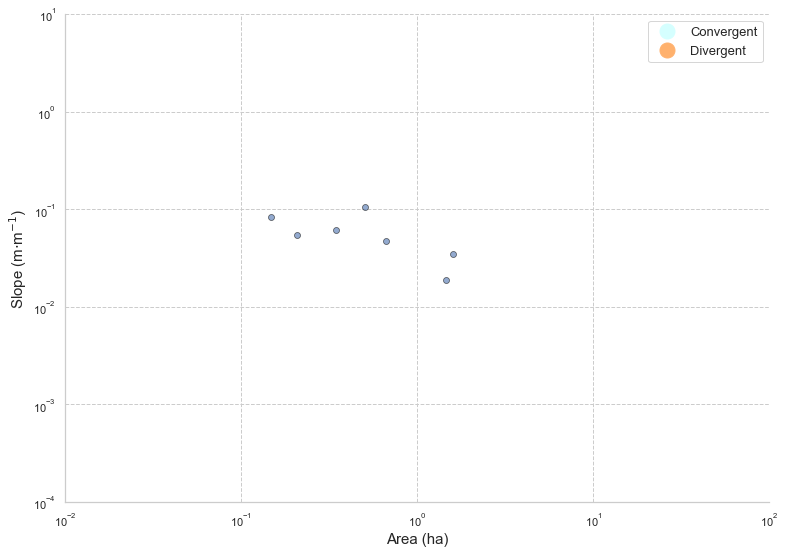

In [98]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_to_plot
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.01,100)
ax.set_ylim(0.0001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [ ]:
untransformed_b, untransformed_k, exponent_b, scalar_k, data_used_by_model = thresholdLineFixedB(data_to_plot, 'area', slope_to_use, 0.4)

In [ ]:
data_used_by_model = thresholdLineOnlyCooks(data_to_plot, 'area', slope_to_use)

In [ ]:
data_used_by_model2 = thresholdLineOnlyCooks(data_used_by_model, 'area', slope_to_use)

In [ ]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_used_by_model
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.001,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [ ]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_used_by_model2
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.001,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [ ]:
print('b: ', exponent_b)
print('k: ', scalar_k)

In [96]:
orthogonal_regression_dataset = data_to_plot

In [97]:
# Initiate some data, giving some randomness using random.random().
x = orthogonal_regression_dataset.loc[:,'log_area'].values
y = orthogonal_regression_dataset.loc[:,'log_slope'].values

# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c
   
# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(x, y)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[-0.4, -1])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [-0.78521676 -1.5063265 ]
Beta Std Error: [ 0.30436971  0.07956163]
Beta Covariance: [[ 3.33393779  0.63260069]
 [ 0.63260069  0.22780434]]
Residual Variance: 0.027787236839604303
Inverse Condition #: 0.17007159819442264
Reason(s) for Halting:
  Sum of squares convergence


In [98]:
print('b: ', out.beta[0] *-1)
print('k: ', 10**out.beta[1])

b:  0.785216756939
k:  0.0311654567166


In [99]:
b_orth = out.beta[0] 
k_orth = out.beta[1]

In [100]:
k_adjustment_dataset = data_to_plot

In [101]:
target_number_of_points_above_line = np.ceil(len(k_adjustment_dataset)*0.8).astype(int)
adjustment = 0
for u in range(0,100):
    above_model_line = []
    for j in k_adjustment_dataset.index:
        measured_slope = k_adjustment_dataset['log_slope'].loc[j]
        adjusted_intercept = k_orth - adjustment
        model_slope = b_orth * k_adjustment_dataset['log_area'].loc[j] + adjusted_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)                
        else:
            pass
    if len(above_model_line) >= target_number_of_points_above_line:
        break
    else:
        adjustment += 0.01
                

#corrected_set = regression_dataset.drop(above_model_line, axis='index')


# Generate graph

In [102]:
exponent_b_to_use = b_orth*-1
scalar_k_to_use = 10**adjusted_intercept

In [103]:
graph_data = data_to_plot

In [104]:
model_parameter_k = scalar_k_to_use
model_parameter_b = exponent_b_to_use

In [105]:
generate_area_values = np.arange(0.01, 10, 0.0001)
model_slope = model_parameter_k * (generate_area_values**-model_parameter_b )
df_model_area = pd.DataFrame(generate_area_values)
df_model_area.rename(columns={0: 'area'}, inplace=True)
graph_data['DC'] = 1
reshaped_model_slope = model_slope.reshape(-1,1)
df_model_slope = pd.DataFrame(reshaped_model_slope)
df_model_slope.rename(columns={0: slope_to_use}, inplace=True)
df_model = pd.concat([df_model_slope, df_model_area], axis=1, sort=False)
df_model['DC'] = 3
graph_data['Size'] = 500
df_model['Size'] = 1

df_all_1 = df_model.append(graph_data)

No handles with labels found to put in legend.


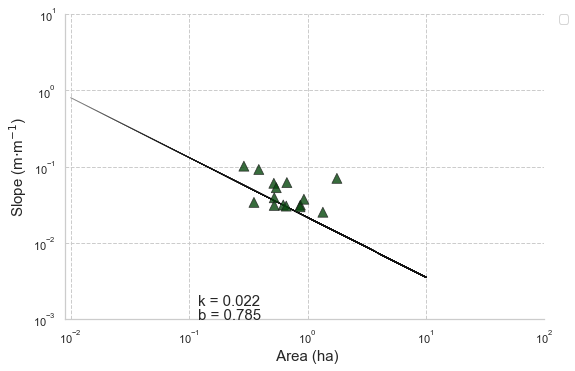

In [106]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
data = df_all_1
colours = {1:'xkcd:forest green', 3:'xkcd:black', 4:'xkcd:forest green'}
x_axis = 'area'
#x_axis_label = x_axis + ' Area (ha)'
x_axis_label = ' Area (ha)'
y_axis = slope_to_use
fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC', 
                 data=data, alpha = 0.8, legend = False, edgecolor="k", 
                  style = 'DC', size = 'Size', sizes = (0.1,100), markers =['^', '.', '.'])

ax = fig.axes[0,0]

ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)

fig.set(xlim = (0.009, 100))
fig.set(ylim = (0.001, 10))

leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

#g1 = Line2D([], [], color='xkcd:orange', marker='s', linestyle='None',
#                          markersize=15, label='Gully head 1 (divergent)')

rs = Line2D([], [], color='xkcd:merlot', marker='^', linestyle='None',
                          markersize=15, label='Random sample (convergent)')

#g2 = Line2D([], [], color='xkcd:scarlet', marker='o', linestyle='None',
#                          markersize=15, label='Gully head 2 (divergent)')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis_label, fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)

plt.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
#plt.legend(handles=[rs, g1, g2],fontsize=13, loc=3)
#plt.legend(handles=[rs],fontsize=13, loc=3)

ax.text(0.12, 0.0015,'k = ' + str(np.round(model_parameter_k, 3)), fontsize=15) 
ax.text(0.12, 0.001,'b = ' + str(np.round(model_parameter_b, 3)), fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
fig.fig.set_size_inches(8,5)

In [ ]:
#all_data_plus_right_gh.to_csv('kf_13.csv')

In [ ]:
cp_node_array = np.isin(grid_nodes,all_data_plus_right_gh['cp'].values).astype('int64')

In [ ]:
initial_gh_node_array = np.isin(grid_nodes,all_data_plus_right_gh['initial'].values).astype('int64')

In [ ]:
downstream_5m_node_array = np.isin(grid_nodes,all_data_plus_right_gh['5m'].values).astype('int64')

In [100]:
final_node_array = np.isin(grid_nodes,all_data_plus_right_gh['final'].values).astype('int64')

In [99]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [101]:
np_array_to_Geotiff('test_fna_pg_7.tif', input_geotiff, final_node_array, catchment_area.dtype)#

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [ ]:
np.sum(cp_node_array)

In [ ]:
list_of_exponents = []
list_of_scalars = []
for r in range(0, 10):
    if r == 0:
        exponent_b, scalar_k, data_used_by_model = thresholdLine(data_to_plot, 'area', slope_to_use)
        list_of_exponents.append(exponent_b)
        list_of_scalars.append(scalar_k)
    else:
        if len(data_used_by_model) > 30:
            exponent_b, scalar_k, data_used_by_model = thresholdLine(data_used_by_model, 'area', slope_to_use)
            list_of_exponents.append(exponent_b)
            list_of_scalars.append(scalar_k)
        else:
            break
        
exponent_to_use = max(list_of_exponents)
scalar_to_use = min(list_of_scalars)